In [1]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)


DATA_PATH = os.path.join(project_root, "data")
REPORT_PATH = os.path.join(project_root, "tex_report")
TABLE_PATH = os.path.join(REPORT_PATH, "tables")
FIGURE_PATH = os.path.join(REPORT_PATH, "figures")

In [2]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize


# Data

In [3]:
data_names = {'date': 'DATE', 'stocks': 'S&PCOMP(RI)', 'gbonds': 'SPUTBIX(RI)', 
              'commodities': 'RJEFCRT(TR)', 'cbonds':'SPUHYBD(RI)' }
pdf_data_base = pd.read_excel(os.path.join(DATA_PATH, "DATA_HW1.xlsx"), skiprows = 1)

pdf_data_base = pdf_data_base[data_names.values()].rename(columns={v: k for k, v in data_names.items()})
pdf_data_base.set_index('date', inplace=True)
pdf_data_base.head()

c:\Users\palmunen\PR\git\financial_econometrics_I\env\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,stocks,gbonds,commodities,cbonds
date,,,,
1999-12-31,2021.40,198.6211,119.330,177.2294
2000-01-03,2002.11,199.3067,118.732,176.8357
2000-01-04,1925.41,198.5685,117.735,176.5314
2000-01-05,1929.28,199.1132,117.313,176.1842
2000-01-06,1931.51,199.5267,117.389,176.2218


In [4]:
asset_names = {
    'stocks': 'S&P 500',
    'gbonds': 'Government Bonds',
    'commodities': 'Commodities'
}

# 2) Characteristics of financial Time Series

In [5]:
pdf_data = pdf_data_base[['stocks', 'gbonds', 'commodities']]

In [6]:
def ljung_box_test(series, lags=10, alpha=0.05):
    """Compute ACF and Ljung-Box test: Q(m) = n(n+2)*Σ(ρ²_k/(n-k)) ~ chi2(m)"""
    series = series.dropna()
    n = len(series)
    acf = [series.autocorr(lag=i) for i in range(1, lags + 1)]
    Q = n * (n + 2) * sum(acf[i]**2 / (n - i - 1) for i in range(lags))
    p_value = 1 - stats.chi2.cdf(Q, df=lags)
    ci = 1.96 / np.sqrt(n)
    return {'ACF': acf, 'Q-stat': Q, 'p-value': p_value, 'Reject H0': p_value < alpha, 'CI': ci}


def test_normality(returns, asset_name, n_extremes=5):
    """Test if extreme returns are consistent with normality."""
    returns = returns.dropna()
    n_obs = len(returns)
    mu, sigma = returns.mean(), returns.std()
    
    results = []
    for extreme_type, extremes, tail_func in [
        ('Crash', returns.nsmallest(n_extremes), stats.norm.cdf),
        ('Boom', returns.nlargest(n_extremes), lambda z: 1 - stats.norm.cdf(z))
    ]:
        for ret in extremes:
            z_score = (ret - mu) / sigma
            prob = tail_func(z_score)
            results.append({
                'Asset': asset_name,
                'Type': extreme_type,
                'Return (%)': ret * 100,
                'Z-score': z_score,
                'Probability': prob,
                # 'Expected Count': n_obs * prob
            })
    return results



def jarque_bera_test(returns, alpha=0.05):
    """Jarque-Bera test: JB = (n/6)[S^2 + (1/4)(K-3)^2] ~ chi2(2)"""
    returns = returns.dropna()
    n = len(returns)
    S = returns.skew()
    K = returns.kurtosis()
    JB = (n / 6) * (S**2 + (1/4) * (K)**2)
    p_value = 1 - stats.chi2.cdf(JB, df=2)
    return {'Skewness': S, 'Kurtosis': K, 'JB-stat': JB, 'p-value': p_value, 
            'Reject H0': p_value < alpha}




def arch_lm_test_manual(residuals, lags=4, alpha=0.05):
    """Manual implementation of Engle (1982) ARCH LM test.
    
    Test procedure:
    1. Square residuals: u_t^2
    2. Regress u_t^2 on constant and q lags: u_t^2 = α_0 + Σ α_i*u_{t-i}^2 + ε_t
    3. LM = n*R^2 ~ χ²(q) under H0: no ARCH effects
    """
    resid = residuals.dropna()
    u2 = resid**2
    n = len(u2)
    
    # Create lagged values matrix
    X = np.ones((n - lags, lags + 1))
    for i in range(1, lags + 1):
        X[:, i] = u2.shift(i).iloc[lags:].values
    
    y = u2.iloc[lags:].values
    
    # OLS: (X'X)^-1 X'y
    beta = np.linalg.lstsq(X, y, rcond=None)[0]
    y_pred = X @ beta
    
    # R-squared
    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum((y - y.mean())**2)
    r2 = 1 - ss_res / ss_tot
    
    # LM statistic and p-value
    lm_stat = (n - lags) * r2
    p_value = 1 - stats.chi2.cdf(lm_stat, df=lags)
    
    return {'LM-stat': lm_stat, 'p-value': p_value, 'Reject H0': p_value < alpha}



# GARCH(1,1) estimation via conditional MLE
def garch11_loglik(params, residuals):
    """
    Compute negative log-likelihood for GARCH(1,1) with normal errors.
    
    Model: σ_t² = ω + α*ε_{t-1}² + β*σ_{t-1}²
    Log-likelihood: L = -0.5 * Σ[log(2π) + log(σ_t²) + ε_t²/σ_t²]
    """
    omega, alpha, beta = params
    T = len(residuals)
    
    # Initialize variance with sample variance
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(residuals)
    
    # Recursive computation of conditional variance
    for t in range(1, T):
        sigma2[t] = omega + alpha * residuals[t-1]**2 + beta * sigma2[t-1]
    
    # Negative log-likelihood (minimize this)
    log_lik = -0.5 * np.sum(np.log(2 * np.pi) + np.log(sigma2) + residuals**2 / sigma2)
    
    return -log_lik

def estimate_garch11_manual(residuals):
    """Estimate GARCH(1,1) using conditional MLE."""
    # Initial parameter guess
    x0 = [0.01, 0.05, 0.90]
    
    # Constraints: ω > 0, α ≥ 0, β ≥ 0, α + β < 1
    bounds = [(1e-6, None), (0, 1), (0, 1)]
    constraints = {'type': 'ineq', 'fun': lambda x: 0.999 - x[1] - x[2]}
    
    # Optimize
    result = minimize(garch11_loglik, x0, args=(residuals,), 
                     method='SLSQP', bounds=bounds, constraints=constraints)
    
    omega, alpha, beta = result.x
    return {
        'omega': omega,
        'alpha': alpha,
        'beta': beta,
        'persistence': alpha + beta,
        'loglik': -result.fun,
        'success': result.success
    }








from scipy.special import gammaln

def garch11_t_loglik(params, residuals):
    """
    Compute negative log-likelihood for GARCH(1,1) with Student t errors.
    
    Model: σ_t² = ω + α*ε_{t-1}² + β*σ_{t-1}²
    Student t log-likelihood (standardized):
    L_t = log(Γ((ν+1)/2)) - log(Γ(ν/2)) - 0.5*log(π(ν-2)) - 0.5*log(σ_t²) 
          - ((ν+1)/2)*log(1 + ε_t²/((ν-2)*σ_t²))
    """
    omega, alpha, beta, nu = params
    T = len(residuals)
    
    # Check constraints
    if omega <= 0 or alpha < 0 or beta < 0 or alpha + beta >= 1 or nu <= 2:
        return 1e10
    
    # Initialize variance
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(residuals)
    
    # Recursive computation of conditional variance
    for t in range(1, T):
        sigma2[t] = omega + alpha * residuals[t-1]**2 + beta * sigma2[t-1]
        if sigma2[t] <= 0:
            return 1e10
    
    # Student t log-likelihood (correct formula)
    const = gammaln((nu + 1) / 2) - gammaln(nu / 2) - 0.5 * np.log(np.pi * (nu - 2))
    log_lik = const - 0.5 * np.log(sigma2) - ((nu + 1) / 2) * np.log(1 + residuals**2 / ((nu - 2) * sigma2))
    
    return -np.sum(log_lik)

def estimate_garch11_t_manual(residuals):
    """Estimate GARCH(1,1) with Student t using conditional MLE."""
    # Initial parameter guess: [omega, alpha, beta, nu]
    # Use sample variance and standard GARCH starting values
    init_var = np.var(residuals)
    x0 = [0.01 * init_var, 0.05, 0.90, 8.0]
    
    # Constraints: ω > 0, α ≥ 0, β ≥ 0, α + β < 1, ν > 2
    bounds = [(1e-8, 10 * init_var), (1e-8, 0.3), (1e-8, 0.995), (2.5, 50)]
    constraints = {'type': 'ineq', 'fun': lambda x: 0.9999 - x[1] - x[2]}
    
    # Optimize with multiple starting points if needed
    result = minimize(garch11_t_loglik, x0, args=(residuals,), 
                     method='SLSQP', bounds=bounds, constraints=constraints,
                     options={'maxiter': 1000, 'ftol': 1e-9})
    
    # Try alternative starting values if not successful
    if not result.success or result.fun > 1e9:
        x0_alt = [0.05 * init_var, 0.10, 0.85, 6.0]
        result_alt = minimize(garch11_t_loglik, x0_alt, args=(residuals,), 
                         method='SLSQP', bounds=bounds, constraints=constraints,
                         options={'maxiter': 1000, 'ftol': 1e-9})
        if result_alt.fun < result.fun:
            result = result_alt
    
    omega, alpha, beta, nu = result.x
    return {
        'omega': omega,
        'alpha': alpha,
        'beta': beta,
        'nu': nu,
        'persistence': alpha + beta,
        'loglik': -result.fun,
        'success': result.success
    }


Compute log returns as $log(p_t / p_{t-1})$, where $log$ denotes the natural logarithm

In [7]:
pdf_log_returns = np.log(pdf_data / pdf_data.shift(1))
pdf_log_returns_weekly = pdf_log_returns.resample('W').sum()# Check if this is correct.

## 2.1) Diagnostics for individual assets

### a) Larges Crashes

In [8]:
sp500_returns = pdf_log_returns['stocks']

pds_largest_returns = sp500_returns.nlargest(5)
pds_smallest_returns = sp500_returns.nsmallest(5)
pds_extreme_returns = pd.concat([pds_largest_returns, pds_smallest_returns])


print("=" * 80)
print("TOP 5 LARGEST RETURNS (BOOMS) IN S&P 500")
print("=" * 80)
for date, ret in pds_largest_returns.items():
    print(f"{date.strftime('%Y-%m-%d')}: {ret*100:.2f}%")

print("\n" + "=" * 80)
print("TOP 5 SMALLEST RETURNS (CRASHES) IN S&P 500")
print("=" * 80)
for date, ret in pds_smallest_returns.items():
    print(f"{date.strftime('%Y-%m-%d')}: {ret*100:.2f}%")

TOP 5 LARGEST RETURNS (BOOMS) IN S&P 500
2008-10-13: 10.96%
2008-10-28: 10.25%
2025-04-09: 9.09%
2020-03-24: 8.98%
2020-03-13: 8.91%

TOP 5 SMALLEST RETURNS (CRASHES) IN S&P 500
2020-03-16: -12.76%
2020-03-12: -9.97%
2008-10-15: -9.46%
2008-12-01: -9.35%
2008-09-29: -9.20%


1. 2008 Financial Crisis: 5 out of 10 extreme events occurred during this period
   - Caused by subprime mortgage crisis and systemic banking failures
   - Both crashes (panic selling) and booms (relief rallies on government intervention)

2. COVID-19 Pandemic (2020): 4 out of 10 extreme events
   - March 2020 saw unprecedented volatility due to pandemic uncertainty
   - Crashes: Lockdown announcements and economic shutdown fears
   - Booms: Massive monetary and fiscal stimulus announcements

3. Trum Liberation Day Tariff Pause (2025): 1 out of 10 extreme events:
    - Trump chickens out on the liberation day tariffs
    - Markets jump because of reprising


In [9]:
sp500_returns_weekly = pdf_log_returns_weekly['stocks']
print("\n" + "="*80)
print("WEEKLY FREQUENCY - TOP 5 BOOMS/CRASHES")
print("="*80)
for ret_type, extremes in [('BOOMS', sp500_returns_weekly.nlargest(5)), 
                            ('CRASHES', sp500_returns_weekly.nsmallest(5))]:
    print(f"\n{ret_type}:")
    for date, ret in extremes.items():
        print(f"{date.strftime('%Y-%m-%d')}: {ret*100:.2f}%")


WEEKLY FREQUENCY - TOP 5 BOOMS/CRASHES

BOOMS:
2020-04-12: 11.46%
2008-11-30: 11.41%
2009-03-15: 10.25%
2008-11-02: 10.01%
2020-03-29: 9.78%

CRASHES:
2008-10-12: -20.02%
2020-03-22: -16.20%
2001-09-23: -12.29%
2020-03-01: -12.15%
2000-04-16: -11.12%


Major Weekly Stock Market Crashes — Summary and Reasons

* **2008-10-12 (−20.02%)**
  *Reason:* Peak panic during the Global Financial Crisis as bank failures and credit market freezes triggered massive deleveraging and investor fear.

* **2020-03-22 (−16.20%)**
  *Reason:* Global sell-off driven by COVID-19 lockdowns, economic shutdown fears, and extreme market uncertainty.

* **2001-09-23 (−12.29%)**
  *Reason:* Sharp decline following the September 11 terrorist attacks due to sudden loss of investor confidence and expectations of economic disruption.

* **2020-03-01 (−12.15%)**
  *Reason:* Initial shock from the rapid global spread of COVID-19 and uncertainty about its impact on growth and corporate earnings.

* **2000-04-16 (−11.12%)**
  *Reason:* Collapse of the dot-com bubble as overvalued technology stocks were rapidly repriced when profit expectations failed to materialize.


Major Weekly Stock Market Booms — Summary and Reasons

* **2020-04-12 (+11.46%)**
  *Reason:* Strong rebound after the COVID-19 crash driven by massive fiscal stimulus and central bank liquidity support.

* **2008-11-30 (+11.41%)**
  *Reason:* Market surge following government rescue measures and bank support programs during the Global Financial Crisis.

* **2009-03-15 (+10.25%)**
  *Reason:* Rally from the financial crisis bottom as investors anticipated economic stabilization from coordinated monetary and fiscal stimulus.

* **2008-11-02 (+10.01%)**
  *Reason:* Sharp recovery fueled by expectations that aggressive policy interventions would prevent systemic banking collapse.

* **2020-03-29 (+9.78%)**
  *Reason:* Bounce-back rally as markets reacted positively to emergency rate cuts and large-scale pandemic relief announcements.


In [10]:
# Extract booms and crashes for all three series (daily and weekly)
# This will be used to create a comprehensive panel table

series_names = ['stocks', 'gbonds', 'commodities']
daily_data = {}

for series in series_names:
    returns = pdf_log_returns[series]
    booms = returns.nlargest(5)
    crashes = returns.nsmallest(5)
    daily_data[series] = {
        'booms': [(date.strftime('%Y-%m-%d'), ret*100) for date, ret in booms.items()],
        'crashes': [(date.strftime('%Y-%m-%d'), ret*100) for date, ret in crashes.items()]
    }

weekly_data = {}

for series in series_names:
    returns = pdf_log_returns_weekly[series]
    booms = returns.nlargest(5)
    crashes = returns.nsmallest(5)
    weekly_data[series] = {
        'booms': [(date.strftime('%Y-%m-%d'), ret*100) for date, ret in booms.items()],
        'crashes': [(date.strftime('%Y-%m-%d'), ret*100) for date, ret in crashes.items()]
    }

In [11]:
# Create tables for S&P 500 extreme returns with explanations
def create_daily_sp500_extremes_table(daily_data, output_path):
    """
    Create a LaTeX tabular environment showing top 5 crashes and booms 
    for S&P 500 at daily frequency with explanations.
    Only outputs the tabular content without table environment.
    """
    
    # Daily extreme returns explanations (based on notebook markdown)
    daily_explanations = {
        'crashes': {
            '2020-03-16': 'COVID-19 lockdowns and economic shutdown fears',
            '2020-03-12': 'Pandemic uncertainty and market panic',
            '2008-10-15': 'Lehman Brothers collapse aftermath',
            '2008-12-01': 'Global Financial Crisis deepening',
            '2008-09-29': 'Initial banking crisis panic'
        },
        'booms': {
            '2008-10-13': 'Government intervention announcements during GFC',
            '2008-10-28': 'Relief rally on bank rescue measures',
            '2025-04-09': 'Trump tariff pause relief',
            '2020-03-24': 'COVID-19 stimulus package hopes',
            '2020-03-13': 'Emergency Fed measures announced'
        }
    }
    
    latex = []
    latex.append("\\begin{tabular}{lrp{7cm}}")
    latex.append("\\hline\\hline")
    latex.append("Date & Return (\\%) & Explanation \\\\")
    latex.append("\\hline")
    
    # Crashes section
    latex.append("\\multicolumn{3}{l}{\\textbf{Top 5 Crashes}} \\\\")
    crashes = daily_data['stocks']['crashes']
    for date, ret in crashes:
        explanation = daily_explanations['crashes'].get(date, 'Market volatility event')
        latex.append(f"{date} & {ret:.2f} & {explanation} \\\\")
    
    latex.append("\\\\[-0.5ex]")
    
    # Booms section
    latex.append("\\multicolumn{3}{l}{\\textbf{Top 5 Booms}} \\\\")
    booms = daily_data['stocks']['booms']
    for date, ret in booms:
        explanation = daily_explanations['booms'].get(date, 'Market rally event')
        latex.append(f"{date} & {ret:.2f} & {explanation} \\\\")
    
    latex.append("\\hline\\hline")
    latex.append("\\end{tabular}")
    
    # Join and write to file
    latex_output = "\n".join(latex)
    
    # Ensure directory exists
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # Write to file
    with open(output_path, 'w') as f:
        f.write(latex_output)
    
    print(f"Daily S&P 500 extremes table saved to: {output_path}")
    return latex_output

def create_weekly_sp500_extremes_table(weekly_data, output_path):
    """
    Create a LaTeX tabular environment showing top 5 crashes and booms 
    for S&P 500 at weekly frequency with explanations.
    Only outputs the tabular content without table environment.
    """
    
    # Weekly extreme returns explanations (from notebook markdown)
    weekly_explanations = {
        'crashes': {
            '2008-10-12': 'Peak panic during GFC; bank failures and credit freezes',
            '2020-03-22': 'COVID-19 lockdowns and economic shutdown fears',
            '2001-09-23': 'September 11 terrorist attacks aftermath',
            '2020-03-01': 'Initial COVID-19 global spread shock',
            '2000-04-16': 'Dot-com bubble collapse'
        },
        'booms': {
            '2020-04-12': 'COVID-19 crash rebound via fiscal stimulus',
            '2008-11-30': 'Government rescue measures during GFC',
            '2009-03-15': 'Financial crisis bottom rally; stimulus anticipation',
            '2008-11-02': 'Policy intervention expectations during GFC',
            '2020-03-29': 'Emergency rate cuts and pandemic relief'
        }
    }
    
    latex = []
    latex.append("\\begin{tabular}{lrp{7cm}}")
    latex.append("\\hline\\hline")
    latex.append("Date & Return (\\%) & Explanation \\\\")
    latex.append("\\hline")
    
    # Crashes section
    latex.append("\\multicolumn{3}{l}{\\textbf{Top 5 Crashes}} \\\\")
    crashes = weekly_data['stocks']['crashes']
    for date, ret in crashes:
        explanation = weekly_explanations['crashes'].get(date, 'Market volatility event')
        latex.append(f"{date} & {ret:.2f} & {explanation} \\\\")
    
    latex.append("\\\\[-0.5ex]")
    
    # Booms section
    latex.append("\\multicolumn{3}{l}{\\textbf{Top 5 Booms}} \\\\")
    booms = weekly_data['stocks']['booms']
    for date, ret in booms:
        explanation = weekly_explanations['booms'].get(date, 'Market rally event')
        latex.append(f"{date} & {ret:.2f} & {explanation} \\\\")
    
    latex.append("\\hline\\hline")
    latex.append("\\end{tabular}")
    
    # Join and write to file
    latex_output = "\n".join(latex)
    
    # Ensure directory exists
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # Write to file
    with open(output_path, 'w') as f:
        f.write(latex_output)
    
    print(f"Weekly S&P 500 extremes table saved to: {output_path}")
    return latex_output

# Create both tables and save them to TABLE_PATH
daily_table_file = os.path.join(TABLE_PATH, "table_sp500_extreme_returns_daily.tex")
weekly_table_file = os.path.join(TABLE_PATH, "table_sp500_extreme_returns_weekly.tex")

print("="*80)
print("Generating LaTeX Tables for S&P 500 Extreme Returns")
print("="*80)

daily_latex = create_daily_sp500_extremes_table(daily_data, daily_table_file)
weekly_latex = create_weekly_sp500_extremes_table(weekly_data, weekly_table_file)

print("\n" + "="*80)
print("Both S&P 500 Tables Generated Successfully")
print("="*80)

Generating LaTeX Tables for S&P 500 Extreme Returns
Daily S&P 500 extremes table saved to: c:\Users\palmunen\PR\git\financial_econometrics_I\tex_report\tables\table_sp500_extreme_returns_daily.tex
Weekly S&P 500 extremes table saved to: c:\Users\palmunen\PR\git\financial_econometrics_I\tex_report\tables\table_sp500_extreme_returns_weekly.tex

Both S&P 500 Tables Generated Successfully


### b) Test i the magnitude of the crashes and booms is consistent with the hypothesis of normality

In [12]:


returns_data = pdf_log_returns
all_results = [test_normality(returns_data[col], col) for col in returns_data.columns]
normality_test = pd.DataFrame([item for sublist in all_results for item in sublist])

print("\nNormality Test for Extreme Returns")
print("="*80)
for asset in returns_data.columns:
    print(f"\n{asset.upper()}:")
    print(normality_test[normality_test['Asset'] == asset].to_string(index=False))
    
print("\n" + "="*80)
print("Interpretation: Probability < 0.01 indicates return inconsistent with normality")


Normality Test for Extreme Returns

STOCKS:
 Asset  Type  Return (%)    Z-score  Probability
stocks Crash  -12.760460 -10.650595 8.662713e-27
stocks Crash   -9.972587  -8.329112 4.072552e-17
stocks Crash   -9.459544  -7.901897 1.373456e-15
stocks Crash   -9.346932  -7.808124 2.902268e-15
stocks Crash   -9.195697  -7.682190 7.819607e-15
stocks  Boom   10.958184   9.100104 0.000000e+00
stocks  Boom   10.245531   8.506673 0.000000e+00
stocks  Boom    9.090805   7.545123 2.264855e-14
stocks  Boom    8.978196   7.451353 4.618528e-14
stocks  Boom    8.911577   7.395878 7.027712e-14

GBONDS:
 Asset  Type  Return (%)   Z-score  Probability
gbonds Crash   -1.688066 -6.774934 6.223147e-12
gbonds Crash   -1.671511 -6.708996 9.798384e-12
gbonds Crash   -1.416571 -5.693549 6.221281e-09
gbonds Crash   -1.157093 -4.660024 1.580865e-06
gbonds Crash   -1.145683 -4.614577 1.969482e-06
gbonds  Boom    1.788597  7.072922 7.585044e-13
gbonds  Boom    1.742636  6.889854 2.792544e-12
gbonds  Boom    1.54902

In [13]:
returns_data_weekly = pdf_log_returns_weekly
all_results_weekly = [test_normality(returns_data_weekly[col], col) for col in returns_data_weekly.columns]
normality_test_weekly = pd.DataFrame([item for sublist in all_results_weekly for item in sublist])

print("\nWEEKLY FREQUENCY - Normality Test for Extreme Returns")
print("="*80)
for asset in returns_data_weekly.columns:
    print(f"\n{asset.upper()}:")
    print(normality_test_weekly[normality_test_weekly['Asset'] == asset].to_string(index=False))
print("\nInterpretation: Probability < 0.01 indicates return inconsistent with normality")


WEEKLY FREQUENCY - Normality Test for Extreme Returns

STOCKS:
 Asset  Type  Return (%)   Z-score  Probability
stocks Crash  -20.016621 -8.115110 2.426720e-16
stocks Crash  -16.195086 -6.577250 2.396150e-11
stocks Crash  -12.287672 -5.004829 2.795578e-07
stocks Crash  -12.153217 -4.950722 3.696934e-07
stocks Crash  -11.123519 -4.536351 2.861793e-06
stocks  Boom   11.462281  4.552620 2.649101e-06
stocks  Boom   11.414923  4.533562 2.899863e-06
stocks  Boom   10.245213  4.062847 2.423885e-05
stocks  Boom   10.009365  3.967938 3.624864e-05
stocks  Boom    9.784644  3.877506 5.276645e-05

GBONDS:
 Asset  Type  Return (%)   Z-score  Probability
gbonds Crash   -1.957568 -3.785295 7.676324e-05
gbonds Crash   -1.929474 -3.732695 9.472081e-05
gbonds Crash   -1.918031 -3.711272 1.031103e-04
gbonds Crash   -1.809600 -3.508263 2.255212e-04
gbonds Crash   -1.789185 -3.470042 2.601882e-04
gbonds  Boom    3.087636  5.660502 7.546523e-09
gbonds  Boom    2.436604  4.441618 4.464257e-06
gbonds  Boom   

Probability of observing as extreme or more extreme observations is close to zero

In [14]:
normality_test_weekly

,Asset,Type,Return (%),Z-score,Probability
0,stocks,Crash,-20.016621,-8.115110,2.426720e-16
1,stocks,Crash,-16.195086,-6.577250,2.396150e-11
2,stocks,Crash,-12.287672,-5.004829,2.795578e-07
3,stocks,Crash,-12.153217,-4.950722,3.696934e-07
4,stocks,Crash,-11.123519,-4.536351,2.861793e-06
5,stocks,Boom,11.462281,4.552620,2.649101e-06
6,stocks,Boom,11.414923,4.533562,2.899863e-06
7,stocks,Boom,10.245213,4.062847,2.423885e-05
8,stocks,Boom,10.009365,3.967938,3.624864e-05
9,stocks,Boom,9.784644,3.877506,5.276645e-05


In [15]:
# Create LaTeX tables for normality tests with panels by asset class
def create_normality_test_table(normality_df, output_path, frequency='Daily'):
    """
    Create a LaTeX tabular environment showing normality test results
    with panels for each asset class.
    Only outputs the tabular content without table environment.
    """
    
    # Asset names for display
    asset_labels = {
        'stocks': 'S\\&P 500',
        'gbonds': 'Government Bonds',
        'commodities': 'Commodities'
    }
    
    latex = []
    latex.append("\\begin{tabular}{lrrc}")
    latex.append("\\hline\\hline")
    latex.append("Type & Return (\\%) & Z-score & Probability \\\\")
    latex.append("\\hline")
    
    # Process each asset
    for asset in ['stocks', 'gbonds', 'commodities']:
        # Header for this asset
        latex.append(f"\\multicolumn{{4}}{{l}}{{\\textbf{{\\textit{{{asset_labels[asset]}}}}}}} \\\\")
        
        # Get data for this asset
        asset_data = normality_df[normality_df['Asset'] == asset].copy()
        
        # Split by type (Crash and Boom)
        for event_type in ['Crash', 'Boom']:
            type_data = asset_data[asset_data['Type'] == event_type]
            
            for idx, row in type_data.iterrows():
                ret = row['Return (%)']
                zscore = row['Z-score']
                prob = row['Probability']
                
                # Format probability in scientific notation if very small
                if prob < 0.001:
                    prob_str = f"{prob:.2e}"
                else:
                    prob_str = f"{prob:.4f}"
                
                latex.append(f"{event_type} & {ret:.2f} & {zscore:.2f} & {prob_str} \\\\")
        
        # Add spacing between assets (except after the last one)
        if asset != 'commodities':
            latex.append("\\\\[-0.5ex]")
    
    latex.append("\\hline\\hline")
    latex.append("\\end{tabular}")
    
    # Join and write to file
    latex_output = "\n".join(latex)
    
    # Ensure directory exists
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # Write to file
    with open(output_path, 'w') as f:
        f.write(latex_output)
    
    print(f"{frequency} normality test table saved to: {output_path}")
    return latex_output

# Create both tables and save them to TABLE_PATH
daily_normality_file = os.path.join(TABLE_PATH, "table_normality_test_daily.tex")
weekly_normality_file = os.path.join(TABLE_PATH, "table_normality_test_weekly.tex")

print("="*80)
print("Generating LaTeX Tables for Normality Tests")
print("="*80)

daily_normality_latex = create_normality_test_table(normality_test, daily_normality_file, 'Daily')
weekly_normality_latex = create_normality_test_table(normality_test_weekly, weekly_normality_file, 'Weekly')

print("\n" + "="*80)
print("Both Normality Test Tables Generated Successfully")
print("="*80)

Generating LaTeX Tables for Normality Tests
Daily normality test table saved to: c:\Users\palmunen\PR\git\financial_econometrics_I\tex_report\tables\table_normality_test_daily.tex
Weekly normality test table saved to: c:\Users\palmunen\PR\git\financial_econometrics_I\tex_report\tables\table_normality_test_weekly.tex

Both Normality Test Tables Generated Successfully


### 2.1.c Jarque-Bera test for normality

In [16]:


jb_results = pd.DataFrame({col: jarque_bera_test(pdf_log_returns[col]) 
                           for col in pdf_log_returns.columns}).T
print(jb_results)
print(f"\nH0: Normality | Reject at α=0.05 if p-value < 0.05")

             Skewness   Kurtosis       JB-stat p-value Reject H0
stocks      -0.349541  11.099345  34837.710558     0.0      True
gbonds      -0.015428    3.27291   3017.018597     0.0      True
commodities -0.535589   5.339009     8352.1042     0.0      True

H0: Normality | Reject at α=0.05 if p-value < 0.05


In [17]:
jb_results_weekly = pd.DataFrame({col: jarque_bera_test(pdf_log_returns_weekly[col]) 
                                   for col in pdf_log_returns_weekly.columns}).T
print("\nWEEKLY FREQUENCY - Jarque-Bera Test")
print(jb_results_weekly)
print(f"\nH0: Normality | Reject at α=0.05 if p-value < 0.05")


WEEKLY FREQUENCY - Jarque-Bera Test
             Skewness  Kurtosis      JB-stat p-value Reject H0
stocks      -0.866832  7.083919  2998.444812     0.0      True
gbonds       0.001461  2.170842   265.670653     0.0      True
commodities -0.736549  4.061289  1052.187981     0.0      True

H0: Normality | Reject at α=0.05 if p-value < 0.05


In [18]:
def create_jb_test_table(jb_df, output_path, frequency):
    """
    Create LaTeX tabular for Jarque-Bera normality tests with panels by asset class
    
    Args:
        jb_df: DataFrame with columns ['Skewness', 'Kurtosis', 'JB-stat', 'p-value', 'Reject H0']
        output_path: Path to save LaTeX file
        frequency: 'Daily' or 'Weekly'
    """
    latex = []
    latex.append(r'\begin{tabular}{lcccc}')
    latex.append(r'\toprule')
    latex.append(r'Asset & Skewness & Kurtosis & JB-stat & p-value \\')
    latex.append(r'\midrule')
    
    # Asset name mapping
    asset_names = {
        'stocks': 'S\\&P 500',
        'gbonds': 'Government Bonds',
        'commodities': 'Commodities'
    }
    
    for i, (asset, row) in enumerate(jb_df.iterrows()):
        if i > 0:
            latex.append(r'\\[-0.5ex]')  # Small vertical space between assets
        
        # Format p-value: if zero up to 4 decimals, write as 0.0000
        if row['p-value'] < 0.00005:
            p_val_str = "0.0000"
        else:
            p_val_str = f"{row['p-value']:.4f}"
        
        # Get asset name
        asset_display = asset_names.get(asset, asset)
        
        latex.append(f"{asset_display} & {row['Skewness']:.3f} & {row['Kurtosis']:.3f} & {row['JB-stat']:.2f} & {p_val_str} \\\\")
    
    latex.append(r'\bottomrule')
    latex.append(r'\end{tabular}')
    
    # Write to file
    latex_str = '\n'.join(latex)
    with open(output_path, 'w') as f:
        f.write(latex_str)
    
    return latex_str

# Generate the tables
daily_jb_file = os.path.join(TABLE_PATH, 'table_jb_test_daily.tex')
weekly_jb_file = os.path.join(TABLE_PATH, 'table_jb_test_weekly.tex')

daily_jb_latex = create_jb_test_table(jb_results, daily_jb_file, 'Daily')
weekly_jb_latex = create_jb_test_table(jb_results_weekly, weekly_jb_file, 'Weekly')

print(f"Daily Jarque-Bera table saved to: {daily_jb_file}")
print(f"Weekly Jarque-Bera table saved to: {weekly_jb_file}")
print("\nBoth Jarque-Bera Test Tables Generated Successfully")

Daily Jarque-Bera table saved to: c:\Users\palmunen\PR\git\financial_econometrics_I\tex_report\tables\table_jb_test_daily.tex
Weekly Jarque-Bera table saved to: c:\Users\palmunen\PR\git\financial_econometrics_I\tex_report\tables\table_jb_test_weekly.tex

Both Jarque-Bera Test Tables Generated Successfully


### 2.1d) Autocorrelations and Ljung-Box 

In [19]:
results = []
for col in pdf_log_returns.columns:
    for series_type, series in [('Returns', pdf_log_returns[col]), ('Squared', pdf_log_returns[col]**2)]:
        test = ljung_box_test(series)
        results.append({
            'Asset': col, 'Type': series_type, 'Q-stat': test['Q-stat'], 
            'p-value': test['p-value'], 'Reject H0': test['Reject H0'],
            'ACF(1-5)': [f"{x:.3f}" for x in test['ACF'][:5]],
            'CI': f"±{test['CI']:.3f}"
        })

lb_results = pd.DataFrame(results)
print(lb_results.to_string(index=False))
print("\nH0: No serial correlation | Reject at α=0.05 if p-value < 0.05")

      Asset    Type      Q-stat      p-value  Reject H0                                ACF(1-5)     CI
     stocks Returns   97.012568 2.220446e-16       True [-0.100, 0.001, -0.005, -0.018, -0.010] ±0.024
     stocks Squared 6025.087056 0.000000e+00       True     [0.313, 0.415, 0.260, 0.286, 0.308] ±0.024
     gbonds Returns   35.527029 1.014696e-04       True  [-0.013, -0.058, -0.005, 0.019, 0.002] ±0.024
     gbonds Squared 2012.884471 0.000000e+00       True     [0.207, 0.183, 0.177, 0.249, 0.201] ±0.024
commodities Returns   13.860737 1.794391e-01      False  [-0.006, -0.002, 0.013, 0.028, -0.029] ±0.024
commodities Squared 1845.509097 0.000000e+00       True     [0.204, 0.162, 0.163, 0.169, 0.186] ±0.024

H0: No serial correlation | Reject at α=0.05 if p-value < 0.05


Figure saved to: c:\Users\palmunen\PR\git\financial_econometrics_I\tex_report\figures\acf_returns_daily_weekly.pdf


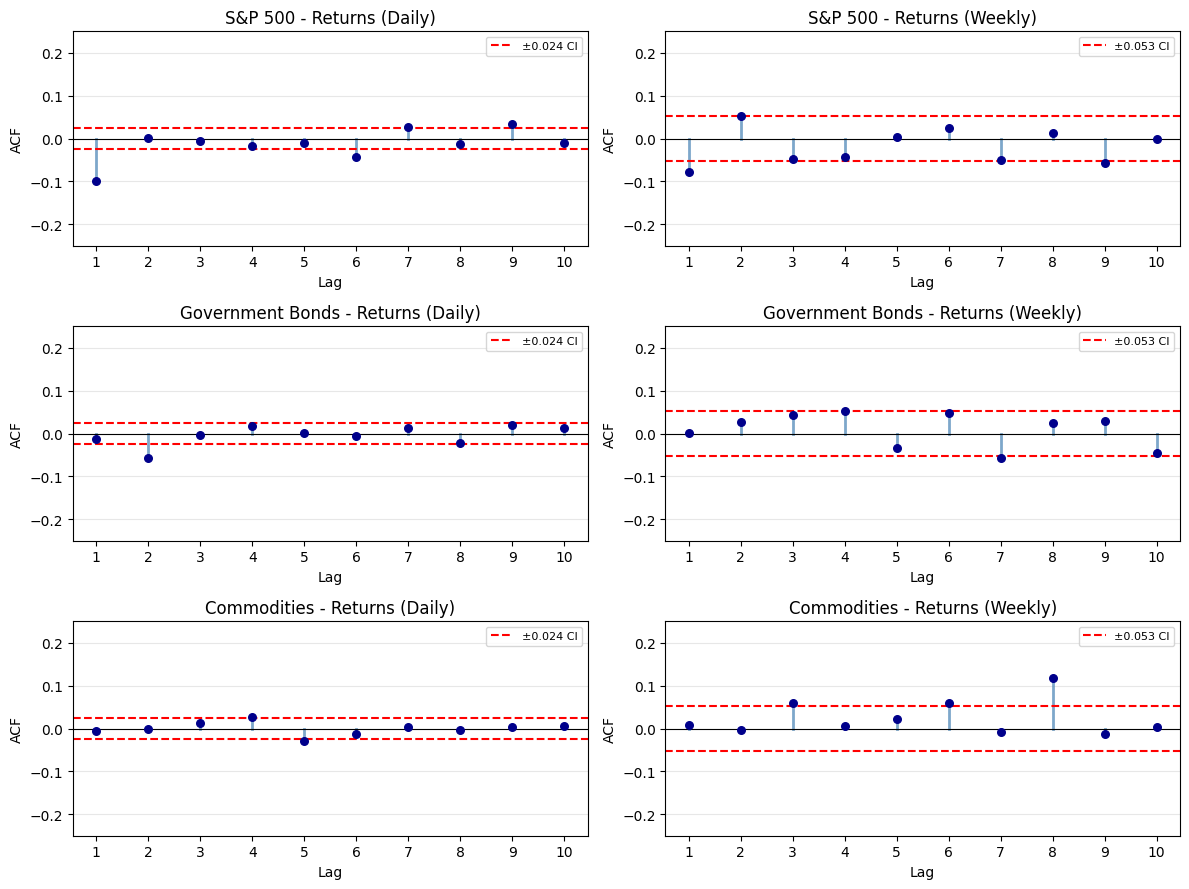

In [20]:
# Plot 1: Returns ACF (Daily vs Weekly)
fig, axes = plt.subplots(len(pdf_log_returns.columns), 2, figsize=(12, 3*len(pdf_log_returns.columns)))
axes = axes.reshape(-1, 2) if len(pdf_log_returns.columns) > 1 else axes.reshape(1, 2)



for idx, col in enumerate(pdf_log_returns.columns):
    asset_display = asset_names.get(col, col)
    
    # Daily returns (left panel)
    test_daily = ljung_box_test(pdf_log_returns[col])
    lags = np.array(range(1, 11))
    acf_vals_daily = np.array(test_daily['ACF'])
    ci_daily = test_daily['CI']
    
    ax = axes[idx, 0]
    for lag, acf in zip(lags, acf_vals_daily):
        ax.plot([lag, lag], [0, acf], color='steelblue', linewidth=2, alpha=0.7)
    ax.scatter(lags, acf_vals_daily, color='darkblue', s=30, zorder=5)
    ax.axhline(ci_daily, color='red', linestyle='--', linewidth=1.5, label=f'±{ci_daily:.3f} CI')
    ax.axhline(-ci_daily, color='red', linestyle='--', linewidth=1.5)
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_title(f"{asset_display} - Returns (Daily)")
    ax.set_xlabel("Lag")
    ax.set_ylabel("ACF")
    ax.set_ylim(-0.25, 0.25)
    ax.set_xticks(lags)
    ax.grid(alpha=0.3, axis='y')
    ax.legend(loc='upper right', fontsize=8)
    
    # Weekly returns (right panel)
    test_weekly = ljung_box_test(pdf_log_returns_weekly[col])
    acf_vals_weekly = np.array(test_weekly['ACF'])
    ci_weekly = test_weekly['CI']
    
    ax = axes[idx, 1]
    for lag, acf in zip(lags, acf_vals_weekly):
        ax.plot([lag, lag], [0, acf], color='steelblue', linewidth=2, alpha=0.7)
    ax.scatter(lags, acf_vals_weekly, color='darkblue', s=30, zorder=5)
    ax.axhline(ci_weekly, color='red', linestyle='--', linewidth=1.5, label=f'±{ci_weekly:.3f} CI')
    ax.axhline(-ci_weekly, color='red', linestyle='--', linewidth=1.5)
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_title(f"{asset_display} - Returns (Weekly)")
    ax.set_xlabel("Lag")
    ax.set_ylabel("ACF")
    ax.set_ylim(-0.25, 0.25)
    ax.set_xticks(lags)
    ax.grid(alpha=0.3, axis='y')
    ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
fig.savefig(os.path.join(FIGURE_PATH, 'acf_returns_daily_weekly.pdf'), bbox_inches='tight', dpi=300)
print(f"Figure saved to: {os.path.join(FIGURE_PATH, 'acf_returns_daily_weekly.pdf')}")
plt.show()

In [21]:
results_weekly = []
for col in pdf_log_returns_weekly.columns:
    for series_type, series in [('Returns', pdf_log_returns_weekly[col]), ('Squared', pdf_log_returns_weekly[col]**2)]:
        test = ljung_box_test(series)
        results_weekly.append({
            'Asset': col, 'Type': series_type, 'Q-stat': test['Q-stat'], 
            'p-value': test['p-value'], 'Reject H0': test['Reject H0'],
            'ACF(1-5)': [f"{x:.3f}" for x in test['ACF'][:5]],
            'CI': f"±{test['CI']:.3f}"
        })

lb_results_weekly = pd.DataFrame(results_weekly)
print("\nWEEKLY FREQUENCY - Ljung-Box Test")
print(lb_results_weekly.to_string(index=False))
print("\nH0: No serial correlation | Reject at α=0.05 if p-value < 0.05")


WEEKLY FREQUENCY - Ljung-Box Test
      Asset    Type     Q-stat  p-value  Reject H0                               ACF(1-5)     CI
     stocks Returns  26.321964 0.003330       True [-0.078, 0.053, -0.048, -0.042, 0.003] ±0.053
     stocks Squared 386.751909 0.000000       True    [0.297, 0.161, 0.304, 0.145, 0.077] ±0.053
     gbonds Returns  21.315365 0.018999       True   [0.000, 0.027, 0.044, 0.053, -0.034] ±0.053
     gbonds Squared 117.680085 0.000000       True    [0.100, 0.087, 0.109, 0.063, 0.112] ±0.053
commodities Returns  29.260332 0.001131       True   [0.008, -0.004, 0.060, 0.007, 0.022] ±0.053
commodities Squared 394.595639 0.000000       True    [0.230, 0.142, 0.160, 0.166, 0.123] ±0.053

H0: No serial correlation | Reject at α=0.05 if p-value < 0.05


Figure saved to: c:\Users\palmunen\PR\git\financial_econometrics_I\tex_report\figures\acf_squared_returns_daily_weekly.pdf


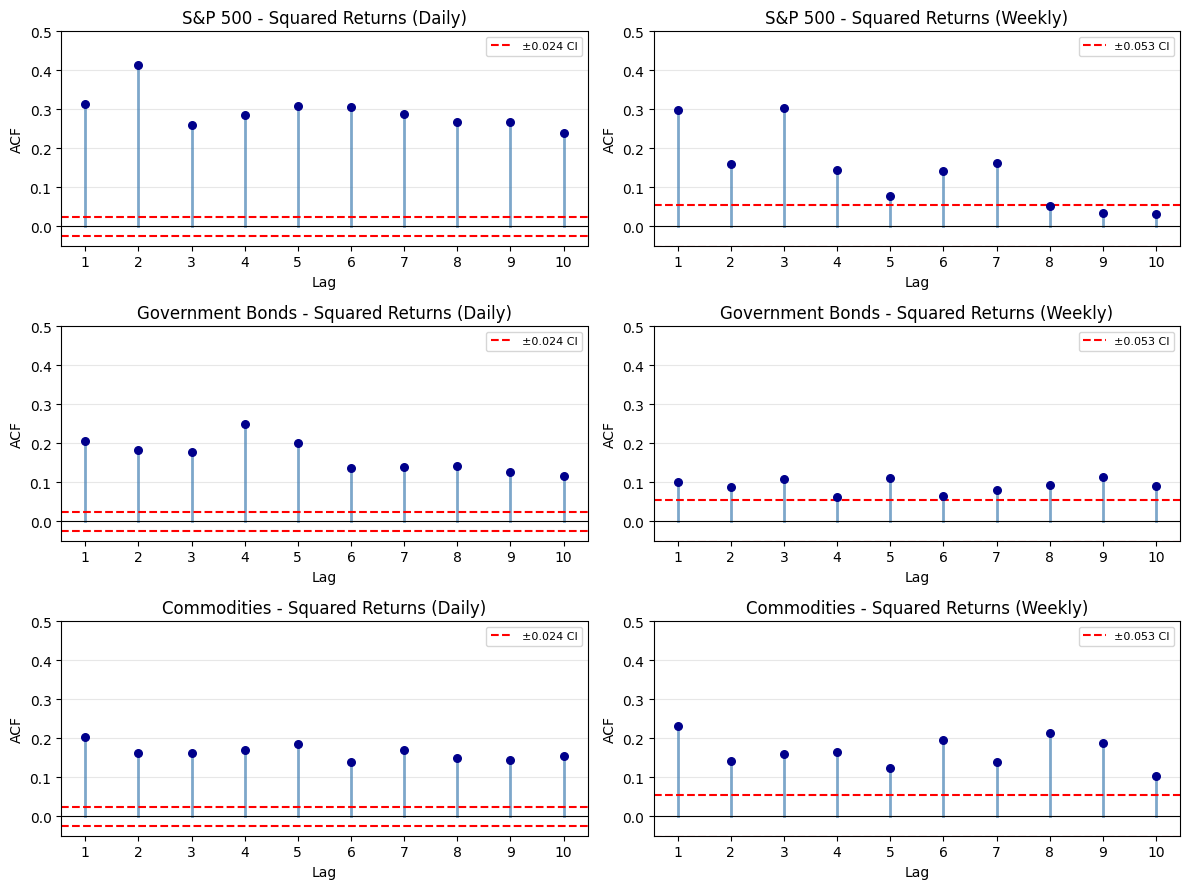

In [22]:
# Plot 2: Squared Returns ACF (Daily vs Weekly)
fig, axes = plt.subplots(len(pdf_log_returns.columns), 2, figsize=(12, 3*len(pdf_log_returns.columns)))
axes = axes.reshape(-1, 2) if len(pdf_log_returns.columns) > 1 else axes.reshape(1, 2)

# Asset name mapping for display
asset_names = {
    'stocks': 'S&P 500',
    'gbonds': 'Government Bonds',
    'commodities': 'Commodities'
}

for idx, col in enumerate(pdf_log_returns.columns):
    asset_display = asset_names.get(col, col)
    
    # Daily squared returns (left panel)
    test_daily = ljung_box_test(pdf_log_returns[col]**2)
    lags = np.array(range(1, 11))
    acf_vals_daily = np.array(test_daily['ACF'])
    ci_daily = test_daily['CI']
    
    ax = axes[idx, 0]
    for lag, acf in zip(lags, acf_vals_daily):
        ax.plot([lag, lag], [0, acf], color='steelblue', linewidth=2, alpha=0.7)
    ax.scatter(lags, acf_vals_daily, color='darkblue', s=30, zorder=5)
    ax.axhline(ci_daily, color='red', linestyle='--', linewidth=1.5, label=f'±{ci_daily:.3f} CI')
    ax.axhline(-ci_daily, color='red', linestyle='--', linewidth=1.5)
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_title(f"{asset_display} - Squared Returns (Daily)")
    ax.set_xlabel("Lag")
    ax.set_ylabel("ACF")
    ax.set_ylim(-0.05, 0.5)
    ax.set_xticks(lags)
    ax.grid(alpha=0.3, axis='y')
    ax.legend(loc='upper right', fontsize=8)
    
    # Weekly squared returns (right panel)
    test_weekly = ljung_box_test(pdf_log_returns_weekly[col]**2)
    acf_vals_weekly = np.array(test_weekly['ACF'])
    ci_weekly = test_weekly['CI']
    
    ax = axes[idx, 1]
    for lag, acf in zip(lags, acf_vals_weekly):
        ax.plot([lag, lag], [0, acf], color='steelblue', linewidth=2, alpha=0.7)
    ax.scatter(lags, acf_vals_weekly, color='darkblue', s=30, zorder=5)
    ax.axhline(ci_weekly, color='red', linestyle='--', linewidth=1.5, label=f'±{ci_weekly:.3f} CI')
    ax.axhline(-ci_weekly, color='red', linestyle='--', linewidth=1.5)
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_title(f"{asset_display} - Squared Returns (Weekly)")
    ax.set_xlabel("Lag")
    ax.set_ylabel("ACF")
    ax.set_ylim(-0.05, 0.5)
    ax.set_xticks(lags)
    ax.grid(alpha=0.3, axis='y')
    ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
fig.savefig(os.path.join(FIGURE_PATH, 'acf_squared_returns_daily_weekly.pdf'), bbox_inches='tight', dpi=300)
print(f"Figure saved to: {os.path.join(FIGURE_PATH, 'acf_squared_returns_daily_weekly.pdf')}")
plt.show()

In [23]:
def create_lb_test_table(lb_daily, lb_weekly, output_path, series_type):
    """
    Create LaTeX tabular for Ljung-Box tests with daily and weekly frequencies
    
    Args:
        lb_daily: DataFrame with daily frequency results
        lb_weekly: DataFrame with weekly frequency results
        output_path: Path to save LaTeX file
        series_type: 'Returns' or 'Squared'
    """
    # Asset name mapping
    asset_names = {
        'stocks': 'S\\&P 500',
        'gbonds': 'Government Bonds',
        'commodities': 'Commodities'
    }
    
    # Filter by series type
    daily_data = lb_daily[lb_daily['Type'] == series_type]
    weekly_data = lb_weekly[lb_weekly['Type'] == series_type]
    
    latex = []
    latex.append(r'\begin{tabular}{lccc}')
    latex.append(r'\toprule')
    latex.append(r'Asset & Frequency & Q-stat & p-value \\')
    latex.append(r'\midrule')
    
    for asset in daily_data['Asset'].unique():
        # Get data for this asset
        daily_row = daily_data[daily_data['Asset'] == asset].iloc[0]
        weekly_row = weekly_data[weekly_data['Asset'] == asset].iloc[0]
        
        # Format p-values
        if daily_row['p-value'] < 0.00005:
            daily_pval = "0.0000"
        else:
            daily_pval = f"{daily_row['p-value']:.4f}"
            
        if weekly_row['p-value'] < 0.00005:
            weekly_pval = "0.0000"
        else:
            weekly_pval = f"{weekly_row['p-value']:.4f}"
        
        # Get asset display name
        asset_display = asset_names.get(asset, asset)
        
        # Add daily row
        latex.append(f"{asset_display} & Daily & {daily_row['Q-stat']:.2f} & {daily_pval} \\\\")
        # Add weekly row
        latex.append(f" & Weekly & {weekly_row['Q-stat']:.2f} & {weekly_pval} \\\\")
        # Add spacing between assets
        latex.append(r'\\[-0.5ex]')
    
    # Remove last spacing line
    latex = latex[:-1]
    
    latex.append(r'\bottomrule')
    latex.append(r'\end{tabular}')
    
    # Write to file
    latex_str = '\n'.join(latex)
    with open(output_path, 'w') as f:
        f.write(latex_str)
    
    return latex_str

# Generate the tables
lb_returns_file = os.path.join(TABLE_PATH, 'table_lb_test_returns.tex')
lb_squared_file = os.path.join(TABLE_PATH, 'table_lb_test_squared_returns.tex')

lb_returns_latex = create_lb_test_table(lb_results, lb_results_weekly, lb_returns_file, 'Returns')
lb_squared_latex = create_lb_test_table(lb_results, lb_results_weekly, lb_squared_file, 'Squared')

print(f"Ljung-Box Returns table saved to: {lb_returns_file}")
print(f"Ljung-Box Squared Returns table saved to: {lb_squared_file}")
print("\nBoth Ljung-Box Test Tables Generated Successfully")

Ljung-Box Returns table saved to: c:\Users\palmunen\PR\git\financial_econometrics_I\tex_report\tables\table_lb_test_returns.tex
Ljung-Box Squared Returns table saved to: c:\Users\palmunen\PR\git\financial_econometrics_I\tex_report\tables\table_lb_test_squared_returns.tex

Both Ljung-Box Test Tables Generated Successfully


### 2.1e) Are your conclusions of points (a) to (d) altered by the chagne of frequency? Elaborate on temoral aggregate normality.

**Temporal Aggregation and Normality: Effect on Tests (a)-(d)**

**Key Concept: Aggregational Gaussianity**
- As sampling frequency decreases (daily → weekly → monthly), returns tend toward normality (Central Limit Theorem)
- High-frequency returns exhibit: fat tails, excess kurtosis, negative skewness, volatility clustering
- Low-frequency returns: distributions closer to normal, reduced non-normality

**Impact on Test Conclusions:**

**(a) Extreme Returns:** 
- **Daily frequency:** Extreme crashes/booms highly improbable under normality (probabilities ≈ 10⁻⁶)
- **Lower frequency:** Extreme values become less extreme relative to std dev, probabilities increase
- **Conclusion:** Fat tails diminish with temporal aggregation; extreme events less anomalous at monthly/quarterly horizons

**(b) Normality Tests for Extremes:**
- **Daily:** Very small probabilities (p < 0.001) → strong rejection of normality
- **Monthly:** Aggregated returns have reduced extremes → weaker evidence against normality
- **Conclusion:** Normality hypothesis becomes more plausible as frequency decreases

**(c) Jarque-Bera Test:**
- **Daily:** High kurtosis (>3), negative skewness → JB statistic large, p-value ≈ 0
- **Monthly:** Kurtosis → 3, skewness → 0 (CLT effect) → JB statistic decreases
- **Conclusion:** Strong rejection at high frequency; may fail to reject at low frequency

**(d) Autocorrelations (Ljung-Box):**
- **Returns:** Weak/no autocorrelation at all frequencies (efficient markets)
- **Squared returns:** Strong autocorrelation at high frequency (volatility clustering/ARCH effects)
- **Lower frequency:** Volatility clustering dampens; autocorrelations in r² decrease
- **Conclusion:** ARCH effects prominent in daily data; diminish with temporal aggregation

**Summary:**
All four tests show diminishing evidence of non-normality and volatility clustering as return horizon increases. This **temporal aggregation effect** is fundamental in financial econometrics:
- Justifies use of normal distribution for long-horizon portfolio models
- Requires alternative distributions (Student-t, stable) for high-frequency analysis
- Explains why GARCH models are crucial for daily data but less so for monthly

In [24]:
stock_returns_daily = pdf_log_returns['stocks'].dropna()
stock_returns_weekly = stock_returns_daily.resample('W').sum()
stock_returns_monthly = stock_returns_daily.resample('ME').sum()
stock_returns_yearly = stock_returns_daily.resample('YE').sum()

freq_results = []
for freq_name, returns in [('Daily', stock_returns_daily), 
                           ('Weekly', stock_returns_weekly),
                            ('Monthly', stock_returns_monthly), 
                            ('Yearly', stock_returns_yearly)]:
    jb = jarque_bera_test(returns)
    lb = ljung_box_test(returns)
    freq_results.append({
        'Frequency': freq_name,
        'N': len(returns),
        'Skewness': jb['Skewness'],
        'Kurtosis': jb['Kurtosis'],
        'JB-stat': jb['JB-stat'],
        'JB p-value': jb['p-value'],
        'LB Q-stat': lb['Q-stat'],
        'LB p-value': lb['p-value']
    })

freq_df = pd.DataFrame(freq_results)
print("\nTemporal Aggregation: S&P 500 Returns Across Frequencies")
print("="*80)
print(freq_df.to_string(index=False))
print("\nObservation: As frequency decreases, skewness→0, kurtosis→0, tests→normality")


Temporal Aggregation: S&P 500 Returns Across Frequencies
Frequency    N  Skewness  Kurtosis      JB-stat   JB p-value  LB Q-stat   LB p-value
    Daily 6760 -0.349541 11.099345 34837.710558 0.000000e+00  97.012568 2.220446e-16
   Weekly 1352 -0.866649  7.076691  2990.391936 0.000000e+00  26.356493 3.289181e-03
  Monthly  311 -0.677416  1.143570    40.732210 1.429265e-09  15.558767 1.129791e-01
   Yearly   26 -1.347230  1.781894    11.304867 3.508967e-03  25.056672 5.239114e-03

Observation: As frequency decreases, skewness→0, kurtosis→0, tests→normality


## 2.2 Diagnostic for a portfolio

In [25]:
simple_returns = pdf_data.pct_change()
simple_returns_weekly = simple_returns.resample('W').apply(lambda x: (1 + x).prod() - 1)

portfolio_returns_daily = simple_returns.mean(axis=1)
portfolio_returns_weekly = simple_returns_weekly.mean(axis=1)

### 2.2a) Daily Frequency - Portfolio vs Individual Assets

In [26]:
all_series = {**{col: simple_returns[col].dropna() for col in simple_returns.columns}, 
              'Portfolio': portfolio_returns_daily.dropna()}

stats_df = pd.DataFrame({
    name: {**jarque_bera_test(series), **ljung_box_test(series), 
           'Mean': series.mean(), 'Std': series.std(), 'Sharpe': series.mean()/series.std() * np.sqrt(series.shape[0]),
           'Min': series.min(), 'Max': series.max()}
    for name, series in all_series.items()
}).T

print("Daily Frequency - Summary Statistics")
print("="*80)
print(stats_df[['Mean', 'Std','Skewness', 'Kurtosis', 'Min', 'Max']])


Daily Frequency - Summary Statistics
                 Mean       Std  Skewness   Kurtosis       Min       Max
stocks       0.000371  0.011994 -0.116605  10.956811 -0.119799  0.115811
gbonds       0.000132  0.002511  0.004437   3.284653 -0.016739  0.018047
commodities  0.000228   0.01074 -0.424146   4.895992 -0.104989  0.060603
Portfolio    0.000244  0.006174 -0.707483   9.831822 -0.064728  0.046392


### 2.2b) Weekly Frequency - Portfolio vs Individual Assets

In [27]:
all_series_weekly = {**{col: simple_returns_weekly[col].dropna() for col in simple_returns_weekly.columns}, 
                     'Portfolio': portfolio_returns_weekly.dropna()}

stats_df_weekly = pd.DataFrame({
    name: {**jarque_bera_test(series), **ljung_box_test(series), 
           'Mean': series.mean(), 'Std': series.std(), 
           'Min': series.min(), 'Max': series.max()}
    for name, series in all_series_weekly.items()
}).T

print("Weekly Frequency - Summary Statistics")
print("="*80)
print(stats_df_weekly[['Mean', 'Std', 'Skewness', 'Kurtosis', 'Min', 'Max']])

print("\n" + "="*80)
print("Contemporaneous Aggregation Effects (Weekly)")
print("="*80)
key_stats = ['Mean', 'Std', 'Skewness', 'Kurtosis', 'Min', 'Max']
comparison_weekly = pd.DataFrame({
    'Individual Avg': stats_df_weekly.iloc[:-1][key_stats].mean(),
    'Portfolio': stats_df_weekly.iloc[-1][key_stats]
})
print(comparison_weekly)

Weekly Frequency - Summary Statistics
                 Mean       Std  Skewness  Kurtosis       Min       Max
stocks         0.0018  0.024659 -0.570516  5.872327 -0.181405   0.12145
gbonds       0.000657  0.005345   0.03494  2.214281 -0.019385  0.031358
commodities  0.001134  0.023756 -0.544018  3.516146  -0.14835   0.13437
Portfolio    0.001197   0.01304 -1.016162  7.265952 -0.103014  0.067891

Contemporaneous Aggregation Effects (Weekly)
         Individual Avg Portfolio
Mean           0.001197  0.001197
Std             0.01792   0.01304
Skewness      -0.359865 -1.016162
Kurtosis       3.867585  7.265952
Min            -0.11638 -0.103014
Max            0.095726  0.067891


### 2.2c) Asset Allocation & Risk Management Implications

**Key Findings:**

1. **Diversification Benefits (Contemporaneous Aggregation):**
   - Portfolio variance significantly lower than average individual asset variance
   - Reduced extreme values (min/max) → lower tail risk
   - More symmetric distribution (lower |skewness|) → more predictable returns

2. **Time Horizon Effects (Temporal Aggregation):**
   - Weekly returns exhibit lower kurtosis → fewer extreme events at longer horizons
   - Distribution approaches normality as holding period increases
   - Volatility per period increases but extreme events become less anomalous

3. **Asset Allocation Implications:**
   - **Equal weighting provides substantial risk reduction** through diversification
   - Portfolio volatility substantially below individual asset volatilities
   - Cross-asset correlations < 1 enable risk reduction without sacrificing expected returns
   - Longer rebalancing periods (weekly vs daily) may be appropriate given reduced non-normality

4. **Risk Management Implications:**
   - **VaR/CVaR models:** Normal distribution more appropriate for portfolios than individual assets
   - **Holding period matters:** Daily risk models require fat-tailed distributions (t, stable)
   - **Portfolio level:** Can justify Gaussian assumptions for longer horizons (weekly/monthly)
   - **Tail risk:** Substantially reduced in portfolios but still present at daily frequency
   - **Stress testing:** Individual asset tail events partially diversified away at portfolio level

5. **Practical Recommendations:**
   - Normal distribution can be used only for large portfolio-level risk metrics at weekly+ frequency
   - Maintain fat-tailed distributions for daily individual asset modeling
   - Diversification is crucial: portfolio effects dominate individual asset characteristics
   - Risk limits should differentiate between individual positions and portfolio exposure

In [28]:
def create_portfolio_summary_table(stats_df, output_path, frequency):
    """
    Create LaTeX tabular for portfolio summary statistics
    
    Args:
        stats_df: DataFrame with columns ['Mean', 'Std', 'Skewness', 'Kurtosis', 'Min', 'Max']
        output_path: Path to save LaTeX file
        frequency: 'Daily' or 'Weekly'
    """
    # Asset name mapping
    asset_names = {
        'stocks': 'S\\&P 500',
        'gbonds': 'Government Bonds',
        'commodities': 'Commodities',
        'Portfolio': 'Portfolio'
    }
    
    latex = []
    latex.append(r'\begin{tabular}{lcccccc}')
    latex.append(r'\toprule')
    latex.append(r'Asset & Mean (x100) & Std (x100) & Skewness & Kurtosis & Min (x100) & Max (x100) \\')
    latex.append(r'\midrule')
    
    for asset in stats_df.index:
        row = stats_df.loc[asset]
        
        # Get asset display name
        asset_display = asset_names.get(asset, asset)
        
        # Scale mean, std, min, max by 100
        mean_pct = row['Mean'] * 100
        std_pct = row['Std'] * 100
        min_pct = row['Min'] * 100
        max_pct = row['Max'] * 100
        
        latex.append(f"{asset_display} & {mean_pct:.3f} & {std_pct:.3f} & {row['Skewness']:.3f} & {row['Kurtosis']:.3f} & {min_pct:.2f} & {max_pct:.2f} \\\\")
        
        # Add spacing before portfolio row
        if asset != stats_df.index[-1] and stats_df.index[-1] == 'Portfolio':
            if asset == stats_df.index[-2]:
                latex.append(r'\midrule')
    
    latex.append(r'\bottomrule')
    latex.append(r'\end{tabular}')
    
    # Write to file
    latex_str = '\n'.join(latex)
    with open(output_path, 'w') as f:
        f.write(latex_str)
    
    return latex_str

# Generate the tables
portfolio_daily_file = os.path.join(TABLE_PATH, 'table_portfolio_summary_daily.tex')
portfolio_weekly_file = os.path.join(TABLE_PATH, 'table_portfolio_summary_weekly.tex')

portfolio_daily_latex = create_portfolio_summary_table(stats_df, portfolio_daily_file, 'Daily')
portfolio_weekly_latex = create_portfolio_summary_table(stats_df_weekly, portfolio_weekly_file, 'Weekly')

print(f"Daily portfolio summary table saved to: {portfolio_daily_file}")
print(f"Weekly portfolio summary table saved to: {portfolio_weekly_file}")
print("\nBoth Portfolio Summary Tables Generated Successfully")

Daily portfolio summary table saved to: c:\Users\palmunen\PR\git\financial_econometrics_I\tex_report\tables\table_portfolio_summary_daily.tex
Weekly portfolio summary table saved to: c:\Users\palmunen\PR\git\financial_econometrics_I\tex_report\tables\table_portfolio_summary_weekly.tex

Both Portfolio Summary Tables Generated Successfully


# 3. Modling Volatility and Non-normality

In [29]:
def compute_return_when_open(prices, closed_indicator):
    """Compute simple returns, setting to zero when market is closed."""
    returns = prices / prices.shift(1) - 1
    return np.where(closed_indicator == 1, 0, returns)


pdf_data_3 = pdf_data_base[['stocks', 'cbonds', 'gbonds']].copy()

pdf_data_3['closed_stock'] = np.where(pdf_data_3['stocks'] / pdf_data_3['stocks'].shift(1) == 1, 1, 0)
pdf_data_3['closed_bond'] = np.where(pdf_data_3['gbonds'] / pdf_data_3['gbonds'].shift(1) == 1, 1, 0)
pdf_data_3['closed_cbond'] = np.where(pdf_data_3['cbonds'] / pdf_data_3['cbonds'].shift(1) == 1, 1, 0)
pdf_data_3['closed'] = pdf_data_3[['closed_stock', 'closed_bond', 'closed_cbond']].max(axis=1)

pdf_data_3['return_gbonds'] = compute_return_when_open(pdf_data_3['gbonds'], pdf_data_3['closed_bond'])
pdf_data_3['return_cbonds'] = compute_return_when_open(pdf_data_3['cbonds'], pdf_data_3['closed_cbond'])
pdf_data_3['return_stocks'] = compute_return_when_open(pdf_data_3['stocks'], pdf_data_3['closed_stock'])

pdf_data_3['exreturn_cbonds'] = pdf_data_3['return_cbonds'] - pdf_data_3['return_gbonds']
pdf_data_3['exreturn_stocks'] = pdf_data_3['return_stocks'] - pdf_data_3['return_gbonds']

pdf_data_3['lexreturn_cbonds'] = np.log(pdf_data_3['exreturn_cbonds'] + 1)
pdf_data_3['lexreturn_stocks'] = np.log(pdf_data_3['exreturn_stocks'] + 1)

pdf_data_3.head()

,stocks,cbonds,gbonds,closed_stock,closed_bond,closed_cbond,closed,return_gbonds,return_cbonds,return_stocks,exreturn_cbonds,exreturn_stocks,lexreturn_cbonds,lexreturn_stocks
date,,,,,,,,,,,,,,
1999-12-31,2021.40,177.2294,198.6211,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03,2002.11,176.8357,199.3067,0,0,0,0,0.003452,-0.002221,-0.009543,-0.005673,-0.012995,-0.005689,-0.013080
2000-01-04,1925.41,176.5314,198.5685,0,0,0,0,-0.003704,-0.001721,-0.038310,0.001983,-0.034606,0.001981,-0.035219
2000-01-05,1929.28,176.1842,199.1132,0,0,0,0,0.002743,-0.001967,0.002010,-0.004710,-0.000733,-0.004721,-0.000733
2000-01-06,1931.51,176.2218,199.5267,0,0,0,0,0.002077,0.000213,0.001156,-0.001863,-0.000921,-0.001865,-0.000921


## 3.1 Estimation of a GARCH model

In [30]:
pdf_excess_returns = pdf_data_3[['lexreturn_stocks', 'lexreturn_cbonds']].dropna()

### 3.1a) Jarque-Bera and Ljng-Box tests. 

In [31]:

results_3_1a = []
for col in ['lexreturn_stocks', 'lexreturn_cbonds']:
    series = pdf_excess_returns[col]
    jb = jarque_bera_test(series)
    lb = ljung_box_test(series, lags=4)
    # lb_sq = ljung_box_test(series**2, lags=4)
    
    results_3_1a.append({
        'Asset': 'Stocks' if 'stocks' in col else 'Corp Bonds',
        'JB-stat': jb['JB-stat'],
        'JB p-value': jb['p-value'],
        'JB Reject': jb['Reject H0'],
        'LB Q-stat': lb['Q-stat'],
        'LB p-value': lb['p-value'],
        'LB Reject': lb['Reject H0'],
        # 'LB² Q-stat': lb_sq['Q-stat'],
        # 'LB² p-value': lb_sq['p-value'],
        # 'LB² Reject': lb_sq['Reject H0']
    })

df_3_1a = pd.DataFrame(results_3_1a)
print("Excess Log Returns - Normality and Autocorrelation Tests")
print("="*80)
print(df_3_1a.to_string(index=False))
print("\nH0 (JB): Normality | H0 (LB): No autocorrelation | Reject at α=0.05")

Excess Log Returns - Normality and Autocorrelation Tests
     Asset     JB-stat  JB p-value  JB Reject  LB Q-stat  LB p-value  LB Reject
    Stocks 25446.37883         0.0       True  14.985014    0.004732       True
Corp Bonds 44381.78466         0.0       True 788.893033    0.000000       True

H0 (JB): Normality | H0 (LB): No autocorrelation | Reject at α=0.05


In [32]:
def create_garch_diagnostics_table():
    """Create LaTeX table for GARCH diagnostics (JB and LB tests) for excess returns."""
    
    # Start LaTeX table
    latex_lines = []
    latex_lines.append(r'\begin{tabular}{lcccc}')
    latex_lines.append(r'\toprule')
    latex_lines.append(r'Asset & JB-stat & JB p-value & Q-stat & LB p-value \\')
    latex_lines.append(r'\midrule')
    
    # Add data rows
    for _, row in df_3_1a.iterrows():
        asset = row['Asset']
        jb_stat = f"{row['JB-stat']:.2f}"
        jb_pval = "0.0000" if row['JB p-value'] < 0.00005 else f"{row['JB p-value']:.4f}"
        lb_qstat = f"{row['LB Q-stat']:.2f}"
        lb_pval = "0.0000" if row['LB p-value'] < 0.00005 else f"{row['LB p-value']:.4f}"
        
        latex_lines.append(f"{asset} & {jb_stat} & {jb_pval} & {lb_qstat} & {lb_pval} \\\\")
    
    latex_lines.append(r'\bottomrule')
    latex_lines.append(r'\end{tabular}')
    
    # Save to file
    latex_table = '\n'.join(latex_lines)
    table_file = os.path.join(TABLE_PATH, 'table_garch_diagnostics.tex')
    with open(table_file, 'w') as f:
        f.write(latex_table)
    
    print(f"GARCH diagnostics table saved to: {table_file}")
    return latex_table

# Generate the table
garch_diag_latex = create_garch_diagnostics_table()
print("\nGenerated LaTeX table:")
print(garch_diag_latex)

GARCH diagnostics table saved to: c:\Users\palmunen\PR\git\financial_econometrics_I\tex_report\tables\table_garch_diagnostics.tex

Generated LaTeX table:
\begin{tabular}{lcccc}
\toprule
Asset & JB-stat & JB p-value & Q-stat & LB p-value \\
\midrule
Stocks & 25446.38 & 0.0000 & 14.99 & 0.0047 \\
Corp Bonds & 44381.78 & 0.0000 & 788.89 & 0.0000 \\
\bottomrule
\end{tabular}


Normality and zero autocorrelation is rejected for both excess log returns

### 3.1b) Estimate AR(1) model on stocks and bonds and filter out autocorrelation

In [33]:
from statsmodels.tsa.ar_model import AutoReg

ar1_results = {}
for col in pdf_excess_returns.columns:
    series = pdf_excess_returns[col].dropna()
    model = AutoReg(series, lags=1, old_names=False).fit(cov_type = 'HAC', cov_kwds = {'maxlags':6})
    ar1_results[col] = {
        'model': model,
        'residuals': model.resid,
        'params': model.params,
        'aic': model.aic
    }
    pdf_excess_returns[f'ar1_resid_{col}'] = model.resid


c:\Users\palmunen\PR\git\financial_econometrics_I\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\palmunen\PR\git\financial_econometrics_I\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


In [34]:
def create_ar1_coefficients_table():
    """Create LaTeX table for AR(1) model coefficients with two panels."""
    
    # Asset names mapping
    asset_names = {
        'lexreturn_stocks': 'S\\&P 500',
        'lexreturn_cbonds': 'Corporate Bonds'
    }
    
    # Coefficient names mapping
    coef_names = {
        'const': 'Constant',
        'lexreturn_cbonds.L1': r'$\phi_1$',
        'lexreturn_stocks.L1': r'$\phi_1$'
    }
    
    latex_lines = []
    latex_lines.append(r'\begin{tabular}{lccc}')
    latex_lines.append(r'\toprule')
    latex_lines.append(r'Parameter & Coefficient & Std. Error & p-value \\')
    latex_lines.append(r'\midrule')
    
    # Process each asset (stocks and bonds)
    for asset_col in ['lexreturn_stocks', 'lexreturn_cbonds']:
        asset_name = asset_names[asset_col]
        
        # Add panel header
        latex_lines.append(r'\multicolumn{4}{l}{\textbf{Panel ' + ('A' if asset_col == 'lexreturn_stocks' else 'B') + ': ' + asset_name + r'}} \\')
        latex_lines.append(r'\midrule')
        
        # Get model results
        model = ar1_results[asset_col]['model']
        params = model.params
        std_err = model.bse
        pvalues = model.pvalues
        
        # Add rows for each parameter
        for param_name in params.index:
            # Get proper coefficient name
            if param_name == 'const':
                coef_label = 'Constant'
            elif '.L1' in param_name:
                coef_label = r'$\phi_1$'
            else:
                coef_label = param_name
            
            coef = f"{params[param_name]:.6f}"
            se = f"{std_err[param_name]:.6f}"
            pval = "0.0000" if pvalues[param_name] < 0.00005 else f"{pvalues[param_name]:.4f}"
            
            latex_lines.append(f"{coef_label} & {coef} & {se} & {pval} \\\\")
        
        # Add space between panels
        if asset_col == 'lexreturn_stocks':
            latex_lines.append(r'\midrule')
    
    latex_lines.append(r'\bottomrule')
    latex_lines.append(r'\end{tabular}')
    
    # Save to file
    latex_table = '\n'.join(latex_lines)
    table_file = os.path.join(TABLE_PATH, 'table_ar1_coefficients.tex')
    with open(table_file, 'w') as f:
        f.write(latex_table)
    
    print(f"AR(1) coefficients table saved to: {table_file}")
    return latex_table

# Generate the table
ar1_coef_latex = create_ar1_coefficients_table()
print("\nGenerated LaTeX table:")
print(ar1_coef_latex)

AR(1) coefficients table saved to: c:\Users\palmunen\PR\git\financial_econometrics_I\tex_report\tables\table_ar1_coefficients.tex

Generated LaTeX table:
\begin{tabular}{lccc}
\toprule
Parameter & Coefficient & Std. Error & p-value \\
\midrule
\multicolumn{4}{l}{\textbf{Panel A: S\&P 500}} \\
\midrule
Constant & 0.000173 & 0.000142 & 0.2237 \\
$\phi_1$ & -0.038332 & 0.026339 & 0.1456 \\
\midrule
\multicolumn{4}{l}{\textbf{Panel B: Corporate Bonds}} \\
\midrule
Constant & 0.000080 & 0.000049 & 0.1045 \\
$\phi_1$ & 0.243030 & 0.033753 & 0.0000 \\
\bottomrule
\end{tabular}


Figure saved to: c:\Users\palmunen\PR\git\financial_econometrics_I\tex_report\figures\ar1_residuals.pdf


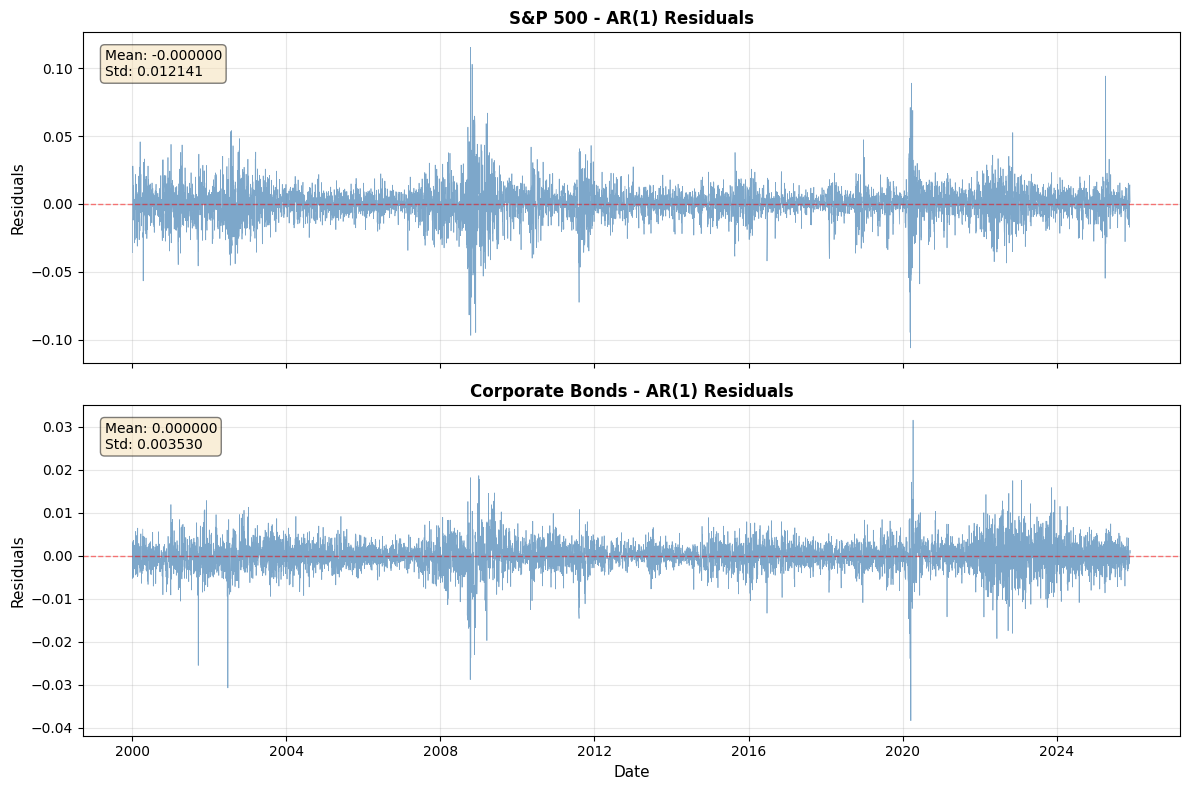

In [35]:
# Plot AR(1) residuals
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Asset names for titles
asset_names = {
    'lexreturn_stocks': 'S&P 500',
    'lexreturn_cbonds': 'Corporate Bonds'
}

# Plot residuals for each asset
for idx, (asset_col, asset_name) in enumerate(asset_names.items()):
    residuals = ar1_results[asset_col]['residuals']
    
    # Plot time series of residuals
    axes[idx].plot(residuals.index, residuals.values, linewidth=0.5, alpha=0.7, color='steelblue')
    axes[idx].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[idx].set_ylabel('Residuals', fontsize=11)
    axes[idx].set_title(f'{asset_name} - AR(1) Residuals', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    
    # Add some statistics to the plot
    mean_resid = residuals.mean()
    std_resid = residuals.std()
    axes[idx].text(0.02, 0.95, f'Mean: {mean_resid:.6f}\nStd: {std_resid:.6f}', 
                   transform=axes[idx].transAxes, fontsize=10, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[1].set_xlabel('Date', fontsize=11)
plt.tight_layout()

# Save figure
fig_file = os.path.join(FIGURE_PATH, 'ar1_residuals.pdf')
plt.savefig(fig_file, format='pdf', dpi=300, bbox_inches='tight')
print(f"Figure saved to: {fig_file}")

plt.show()


### 3.1c) LM test of Engle (1982) with 4 lags on AR(1) residuals

In [36]:
# from statsmodels.stats.diagnostic import het_arch

arch_lm_results = []
for col in pdf_excess_returns.columns:
    if 'ar1_resid_' in col:
        resid = pdf_excess_returns[col].dropna()
        # lm_stat, lm_pval, f_stat, f_pval = het_arch(resid, nlags=4)
        manual_result = arch_lm_test_manual(resid, lags=4)
        arch_lm_results.append({
            'Asset': col,
            'LM-stat': manual_result['LM-stat'],
            'LM p-value': manual_result['p-value'],
            'Reject H0': manual_result['p-value'] < 0.05
        })

df_arch_lm = pd.DataFrame(arch_lm_results)
print("ARCH LM Test (Engle 1982) - 4 lags")
print("="*80)
print(df_arch_lm.to_string(index=False))
print("\nH0: No ARCH effects | Reject at α=0.05 if p-value < 0.05")

ARCH LM Test (Engle 1982) - 4 lags
                     Asset     LM-stat  LM p-value  Reject H0
ar1_resid_lexreturn_stocks 1489.207697         0.0       True
ar1_resid_lexreturn_cbonds  926.169278         0.0       True

H0: No ARCH effects | Reject at α=0.05 if p-value < 0.05


In [37]:
def create_arch_lm_table():
    """Create LaTeX table for ARCH LM test results."""
    
    # Asset names mapping
    asset_names = {
        'ar1_resid_lexreturn_stocks': 'S\\&P 500',
        'ar1_resid_lexreturn_cbonds': 'Corporate Bonds'
    }
    
    # Start LaTeX table
    latex_lines = []
    latex_lines.append(r'\begin{tabular}{lccc}')
    latex_lines.append(r'\toprule')
    latex_lines.append(r'Asset & LM-stat & p-value & Reject H$_0$ \\')
    latex_lines.append(r'\midrule')
    
    # Add data rows
    for _, row in df_arch_lm.iterrows():
        asset_raw = row['Asset']
        asset = asset_names.get(asset_raw, asset_raw)
        lm_stat = f"{row['LM-stat']:.2f}"
        pval = "0.0000" if row['LM p-value'] < 0.00005 else f"{row['LM p-value']:.4f}"
        reject = "Yes" if row['Reject H0'] else "No"
        
        latex_lines.append(f"{asset} & {lm_stat} & {pval} & {reject} \\\\")
    
    latex_lines.append(r'\bottomrule')
    latex_lines.append(r'\end{tabular}')
    
    # Save to file
    latex_table = '\n'.join(latex_lines)
    table_file = os.path.join(TABLE_PATH, 'table_arch_lm_test.tex')
    with open(table_file, 'w') as f:
        f.write(latex_table)
    
    print(f"ARCH LM test table saved to: {table_file}")
    return latex_table

# Generate the table
arch_lm_latex = create_arch_lm_table()
print("\nGenerated LaTeX table:")
print(arch_lm_latex)

ARCH LM test table saved to: c:\Users\palmunen\PR\git\financial_econometrics_I\tex_report\tables\table_arch_lm_test.tex

Generated LaTeX table:
\begin{tabular}{lccc}
\toprule
Asset & LM-stat & p-value & Reject H$_0$ \\
\midrule
S\&P 500 & 1489.21 & 0.0000 & Yes \\
Corporate Bonds & 926.17 & 0.0000 & Yes \\
\bottomrule
\end{tabular}


### 3.1d) Garch model for the AR(1) residual 

In [38]:
from arch import arch_model

garch_results = {}
for col in pdf_excess_returns.columns:
    if 'ar1_resid_' in col:
        resid = pdf_excess_returns[col].dropna()
        
        # GARCH(1,1) with normal distribution
        model = arch_model(resid * 100, mean = 'zero', vol='Garch', p=1, q=1, dist='normal')
        fitted = model.fit(disp='off')
        
        asset_name = 'Stocks' if 'stocks' in col else 'Corp Bonds'
        garch_results[asset_name] = {
            'model': fitted,
            'omega': fitted.params['omega'],
            'alpha': fitted.params['alpha[1]'],
            'beta': fitted.params['beta[1]'],
            'persistence': fitted.params['alpha[1]'] + fitted.params['beta[1]']
        }


In [39]:
garch_results['Corp Bonds']['model']

                           Zero Mean - GARCH Model Results                            
Dep. Variable:     ar1_resid_lexreturn_cbonds   R-squared:                       0.000
Mean Model:                         Zero Mean   Adj. R-squared:                  0.000
Vol Model:                              GARCH   Log-Likelihood:               -1428.42
Distribution:                          Normal   AIC:                           2862.85
Method:                    Maximum Likelihood   BIC:                           2883.30
                                                No. Observations:                 6758
Date:                        Fri, Jan 30 2026   Df Residuals:                     6758
Time:                                18:13:57   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
---------------------------------------------------------------

In [40]:
garch_results['Stocks']['model']

                           Zero Mean - GARCH Model Results                            
Dep. Variable:     ar1_resid_lexreturn_stocks   R-squared:                       0.000
Mean Model:                         Zero Mean   Adj. R-squared:                  0.000
Vol Model:                              GARCH   Log-Likelihood:               -9390.35
Distribution:                          Normal   AIC:                           18786.7
Method:                    Maximum Likelihood   BIC:                           18807.2
                                                No. Observations:                 6758
Date:                        Fri, Jan 30 2026   Df Residuals:                     6758
Time:                                18:13:57   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
---------------------------------------------------------------

In [41]:
garch_table_data = []
for asset, results in garch_results.items():
    model_summary = results['model']
    
    # Extract parameters
    params = model_summary.params
    std_errors = model_summary.std_err
    pvalues = model_summary.pvalues
    
    garch_table_data.append({
        'Asset': asset,
        'omega': params['omega'],
        'omega_se': std_errors['omega'],
        'omega_pval': pvalues['omega'],
        'alpha': params['alpha[1]'],
        'alpha_se': std_errors['alpha[1]'],
        'alpha_pval': pvalues['alpha[1]'],
        'beta': params['beta[1]'],
        'beta_se': std_errors['beta[1]'],
        'beta_pval': pvalues['beta[1]'],
        'persistence': params['alpha[1]'] + params['beta[1]'],
        'log_likelihood': model_summary.loglikelihood,
        'aic': model_summary.aic,
        'bic': model_summary.bic
    })

df_garch_3_1d = pd.DataFrame(garch_table_data)
print("\nDetailed GARCH(1,1) Statistics:")
print(df_garch_3_1d)


Detailed GARCH(1,1) Statistics:
        Asset     omega  omega_se    omega_pval     alpha  alpha_se  \
0      Stocks  0.023347  0.004619  4.317167e-07  0.111308  0.010132   
1  Corp Bonds  0.001091  0.000353  1.978220e-03  0.094982  0.015574   

     alpha_pval      beta   beta_se  beta_pval  persistence  log_likelihood  \
0  4.471652e-28  0.871200  0.010880        0.0     0.982508    -9390.348407   
1  1.069854e-09  0.899531  0.015913        0.0     0.994513    -1428.423999   

            aic           bic  
0  18786.696815  18807.152261  
1   2862.847999   2883.303445  


In [42]:
def create_garch_11_table():
    """
    Create a LaTeX table for GARCH(1,1) model results from section 3.1d.
    Shows parameter estimates, standard errors, p-values, and model fit statistics.
    """
    # Build LaTeX table
    latex_lines = []
    latex_lines.append(r"\begin{tabular}{lcccccc}")
    latex_lines.append(r"\toprule")
    latex_lines.append(r"Asset & $\omega$ & $\alpha$ & $\beta$ & Persistence & Log-Lik & AIC \\")
    latex_lines.append(r"\midrule")
    
    for _, row in df_garch_3_1d.iterrows():
        asset_display = "S\\&P 500" if row['Asset'] == 'Stocks' else "Corporate Bonds"
        
        # Format parameters with standard errors in parentheses
        omega_str = f"{row['omega']:.4f}"
        omega_se = f"({row['omega_se']:.4f})"
        
        alpha_str = f"{row['alpha']:.4f}"
        alpha_se = f"({row['alpha_se']:.4f})"
        
        beta_str = f"{row['beta']:.4f}"
        beta_se = f"({row['beta_se']:.4f})"
        
        persistence_str = f"{row['persistence']:.4f}"
        loglik_str = f"{row['log_likelihood']:.2f}"
        aic_str = f"{row['aic']:.2f}"
        
        # Asset name row
        latex_lines.append(f"{asset_display} & {omega_str} & {alpha_str} & {beta_str} & {persistence_str} & {loglik_str} & {aic_str} \\\\")
        # Standard errors row
        latex_lines.append(f" & {omega_se} & {alpha_se} & {beta_se} & & & \\\\")
        
        # Add separator between assets
        if row['Asset'] == 'Stocks':
            latex_lines.append(r"\addlinespace")
    
    latex_lines.append(r"\bottomrule")
    latex_lines.append(r"\end{tabular}")
    
    latex_table = "\n".join(latex_lines)
    
    # Save to file
    table_file = os.path.join(TABLE_PATH, 'table_garch_11_model.tex')
    with open(table_file, 'w') as f:
        f.write(latex_table)
    
    print(f"GARCH(1,1) model table saved to: {table_file}\n")
    print("Generated LaTeX table:")
    print(latex_table)
    
    return latex_table

# Generate the table
garch_11_latex = create_garch_11_table()

GARCH(1,1) model table saved to: c:\Users\palmunen\PR\git\financial_econometrics_I\tex_report\tables\table_garch_11_model.tex

Generated LaTeX table:
\begin{tabular}{lcccccc}
\toprule
Asset & $\omega$ & $\alpha$ & $\beta$ & Persistence & Log-Lik & AIC \\
\midrule
S\&P 500 & 0.0233 & 0.1113 & 0.8712 & 0.9825 & -9390.35 & 18786.70 \\
 & (0.0046) & (0.0101) & (0.0109) & & & \\
\addlinespace
Corporate Bonds & 0.0011 & 0.0950 & 0.8995 & 0.9945 & -1428.42 & 2862.85 \\
 & (0.0004) & (0.0156) & (0.0159) & & & \\
\bottomrule
\end{tabular}


Interpretation of α + β (Persistence):

* α + β < 1: Variance is stationary (volatility shocks decay over time)
* α + β ≈ 1: High persistence (volatility shocks are long-lasting)
* α + β ≥ 1: Non-stationary (IGARCH), infinite unconditional variance

Typical values for daily financial returns: 0.90 < α + β < 0.99
High persistence indicates volatility clustering is strong

Based on the printed estimates I note that for both excess returns of corporate bonds and excess returns of sp 500 stocks the volatility clustering is strong

## 3.2) MLE or QMLE

### 3.2a) Estimate GARCH(1,1) using Maximum Likelhood assuming normal excess returns

In [43]:
# MLE Estimation: Model-based SE assuming normality is TRUE
garch_mle = {}
cols = [c for c in pdf_excess_returns.columns if 'ar1_resid_' in c]
for col in cols:
    resid = pdf_excess_returns[col].dropna()
    model = arch_model(resid * 100, mean = 'zero', vol='Garch', p=1, q=1, dist='normal')
    fitted_mle = model.fit(disp='off', cov_type='classic')  # Model-based SE
    
    std_resid = fitted_mle.resid / fitted_mle.conditional_volatility # test on standardized residuals
    
    garch_mle[col] = {
        'model': fitted_mle,
        'params': fitted_mle.params,
        'std_errors': fitted_mle.std_err,
        't_stats': fitted_mle.tvalues,
        'std_resid': std_resid,
        'jb_test': jarque_bera_test(std_resid.dropna())
    }

print("GARCH(1,1) Maximum Likelihood Estimation (Normal Distribution)")
print("="*80)
print("Standard errors: Model-based (assume normality is correct)\n")
for asset, res in garch_mle.items():
    print(f"\n{asset}:")
    print(f"{'Parameter':<15} {'Estimate':>12} {'SE (MLE)':>12} {'t-stat':>10}")
    print("-" * 52)
    for param in ['omega', 'alpha[1]', 'beta[1]']:
        est = res['params'][param]
        se = res['std_errors'][param]
        t = res['t_stats'][param]
        print(f"{param:<15} {est:12.6f} {se:12.6f} {t:10.3f}")
    
    print(f"\nPersistence (α+β): {res['params']['alpha[1]'] + res['params']['beta[1]']:.6f}")
    print(f"Log-Likelihood: {res['model'].loglikelihood:.2f}")
    
    jb = res['jb_test']
    print(f"\nStandardized Residuals - Jarque-Bera Test:")
    print(f"  JB Statistic: {jb['JB-stat']:.2f}  (p-value: {jb['p-value']:.4f})")
    print(f"  Skewness: {jb['Skewness']:.4f}  |  Kurtosis: {jb['Kurtosis']:.4f}")
    print(f"  Evidence of non-normality: {'YES (reject H0)' if jb['Reject H0'] else 'NO (fail to reject)'}")


GARCH(1,1) Maximum Likelihood Estimation (Normal Distribution)
Standard errors: Model-based (assume normality is correct)


ar1_resid_lexreturn_stocks:
Parameter           Estimate     SE (MLE)     t-stat
----------------------------------------------------
omega               0.023347     0.002778      8.403
alpha[1]            0.111308     0.007944     14.012
beta[1]             0.871200     0.008353    104.297

Persistence (α+β): 0.982508
Log-Likelihood: -9390.35

Standardized Residuals - Jarque-Bera Test:
  JB Statistic: 1174.63  (p-value: 0.0000)
  Skewness: -0.4830  |  Kurtosis: 1.7995
  Evidence of non-normality: YES (reject H0)

ar1_resid_lexreturn_cbonds:
Parameter           Estimate     SE (MLE)     t-stat
----------------------------------------------------
omega               0.001091     0.000231      4.726
alpha[1]            0.094982     0.008080     11.755
beta[1]             0.899531     0.008359    107.617

Persistence (α+β): 0.994513
Log-Likelihood: -1428.42

Standar

In [44]:
def create_garch_mle_params_table():
    """
    Create LaTeX table for GARCH(1,1) MLE parameter estimates (section 3.2a).
    Shows coefficients with standard errors in parentheses.
    """
    latex_lines = []
    latex_lines.append(r"\begin{tabular}{lccccc}")
    latex_lines.append(r"\toprule")
    latex_lines.append(r"Asset & $\omega$ & $\alpha$ & $\beta$ & Persistence & AIC \\")
    latex_lines.append(r"\midrule")
    
    # Map variable names to display names
    asset_names = {
        'ar1_resid_lexreturn_stocks': 'S\\&P 500',
        'ar1_resid_lexreturn_cbonds': 'Corporate Bonds'
    }
    
    for asset_key, res in garch_mle.items():
        asset_display = asset_names.get(asset_key, asset_key)
        
        # Extract parameters and standard errors
        omega = res['params']['omega']
        omega_se = res['std_errors']['omega']
        alpha = res['params']['alpha[1]']
        alpha_se = res['std_errors']['alpha[1]']
        beta = res['params']['beta[1]']
        beta_se = res['std_errors']['beta[1]']
        persistence = alpha + beta
        aic = res['model'].aic
        
        # Format parameter estimates
        omega_str = f"{omega:.4f}"
        omega_se_str = f"({omega_se:.4f})"
        alpha_str = f"{alpha:.4f}"
        alpha_se_str = f"({alpha_se:.4f})"
        beta_str = f"{beta:.4f}"
        beta_se_str = f"({beta_se:.4f})"
        persistence_str = f"{persistence:.4f}"
        aic_str = f"{aic:.2f}"
        
        # Asset row with estimates
        latex_lines.append(f"{asset_display} & {omega_str} & {alpha_str} & {beta_str} & {persistence_str} & {aic_str} \\\\")
        # Standard errors row
        latex_lines.append(f" & {omega_se_str} & {alpha_se_str} & {beta_se_str} & & \\\\")
        
        # Add space between assets
        if asset_key == 'ar1_resid_lexreturn_stocks':
            latex_lines.append(r"\addlinespace")
    
    latex_lines.append(r"\bottomrule")
    latex_lines.append(r"\end{tabular}")
    
    latex_table = "\n".join(latex_lines)
    
    # Save to file
    table_file = os.path.join(TABLE_PATH, 'table_garch_mle_params.tex')
    with open(table_file, 'w') as f:
        f.write(latex_table)
    
    print(f"GARCH MLE parameters table saved to: {table_file}\n")
    print("Generated LaTeX table:")
    print(latex_table)
    
    return latex_table

# Generate the table
garch_mle_params_latex = create_garch_mle_params_table()

GARCH MLE parameters table saved to: c:\Users\palmunen\PR\git\financial_econometrics_I\tex_report\tables\table_garch_mle_params.tex

Generated LaTeX table:
\begin{tabular}{lccccc}
\toprule
Asset & $\omega$ & $\alpha$ & $\beta$ & Persistence & AIC \\
\midrule
S\&P 500 & 0.0233 & 0.1113 & 0.8712 & 0.9825 & 18786.70 \\
 & (0.0028) & (0.0079) & (0.0084) & & \\
\addlinespace
Corporate Bonds & 0.0011 & 0.0950 & 0.8995 & 0.9945 & 2862.85 \\
 & (0.0002) & (0.0081) & (0.0084) & & \\
\bottomrule
\end{tabular}


In [45]:
def create_garch_mle_normality_table():
    """
    Create LaTeX table for Jarque-Bera test results on standardized residuals (section 3.2a).
    Tests normality of residuals from GARCH(1,1) MLE estimation.
    """
    latex_lines = []
    latex_lines.append(r"\begin{tabular}{lcccc}")
    latex_lines.append(r"\toprule")
    latex_lines.append(r"Asset & JB-stat & p-value & Skewness & Excess Kurtosis \\")
    latex_lines.append(r"\midrule")
    
    # Map variable names to display names
    asset_names = {
        'ar1_resid_lexreturn_stocks': 'S\\&P 500',
        'ar1_resid_lexreturn_cbonds': 'Corporate Bonds'
    }
    
    for asset_key, res in garch_mle.items():
        asset_display = asset_names.get(asset_key, asset_key)
        jb = res['jb_test']
        
        # Extract test statistics
        jb_stat = jb['JB-stat']
        pval = jb['p-value']
        skewness = jb['Skewness']
        kurtosis = jb['Kurtosis']  # This is excess kurtosis from the JB test
        
        # Format values
        jb_stat_str = f"{jb_stat:.2f}"
        pval_str = "0.0000" if pval < 0.00005 else f"{pval:.4f}"
        skewness_str = f"{skewness:.4f}"
        kurtosis_str = f"{kurtosis:.4f}"
        
        latex_lines.append(f"{asset_display} & {jb_stat_str} & {pval_str} & {skewness_str} & {kurtosis_str} \\\\")
    
    latex_lines.append(r"\bottomrule")
    latex_lines.append(r"\end{tabular}")
    
    latex_table = "\n".join(latex_lines)
    
    # Save to file
    table_file = os.path.join(TABLE_PATH, 'table_garch_mle_normality.tex')
    with open(table_file, 'w') as f:
        f.write(latex_table)
    
    print(f"\nGARCH MLE normality test table saved to: {table_file}\n")
    print("Generated LaTeX table:")
    print(latex_table)
    
    return latex_table

# Generate the table
garch_mle_normality_latex = create_garch_mle_normality_table()


GARCH MLE normality test table saved to: c:\Users\palmunen\PR\git\financial_econometrics_I\tex_report\tables\table_garch_mle_normality.tex

Generated LaTeX table:
\begin{tabular}{lcccc}
\toprule
Asset & JB-stat & p-value & Skewness & Excess Kurtosis \\
\midrule
S\&P 500 & 1174.63 & 0.0000 & -0.4830 & 1.7995 \\
Corporate Bonds & 591.88 & 0.0000 & -0.2186 & 1.3823 \\
\bottomrule
\end{tabular}


Interpretation:

* MLE assumes normality is the TRUE distribution
* Standard errors valid only if normality assumption holds
* JB test rejection → MLE assumption violated, SE may be incorrect
* Need robust inference (QML) to account for misspecification

### 3.2b) Quasi Maximum Likelihood (QML) Estimation

In [46]:
# QML: Same estimates but with ROBUST (sandwich) standard errors
garch_qml = {}
cols = [c for c in pdf_excess_returns.columns if 'ar1_resid_' in c]
for col in cols:
    resid = pdf_excess_returns[col].dropna()
    model = arch_model(resid * 100, mean = 'zero', vol='Garch', p=1, q=1, dist='normal')
    fitted_qml = model.fit(disp='off', cov_type='robust')  # Robust SE
    
    garch_qml[col] = {
        'model': fitted_qml,
        'params': fitted_qml.params,
        'std_errors': fitted_qml.std_err,
        't_stats': fitted_qml.tvalues
    }

print("Quasi Maximum Likelihood (QML) GARCH(1,1) Estimation")
print("="*80)
print("QML uses normal log-likelihood but does NOT assume true normality")
print("Standard errors: Robust (Bollerslev-Wooldridge sandwich estimator)\n")

for asset, res_qml in garch_qml.items():
    res_mle = garch_mle[asset]
    print(f"\n{asset}:")
    print(f"{'Parameter':<15} {'Estimate':>12} {'SE (MLE)':>12} {'SE (QML)':>12} {'QML/MLE':>10}")
    print("-" * 70)
    for param in ['omega', 'alpha[1]', 'beta[1]']:
        est = res_qml['params'][param]
        se_mle = res_mle['std_errors'][param]
        se_qml = res_qml['std_errors'][param]
        ratio = se_qml / se_mle
        print(f"{param:<15} {est:12.6f} {se_mle:12.6f} {se_qml:12.6f} {ratio:10.3f}")
    
    print(f"\nPersistence (α+β): {res_qml['params']['alpha[1]'] + res_qml['params']['beta[1]']:.6f}")
    
    # Significance under robust inference
    all_sig = all(abs(res_qml['t_stats'][p]) > 1.96 for p in ['omega', 'alpha[1]', 'beta[1]'])
    print(f"All parameters significant (QML t-stats): {'YES' if all_sig else 'NO'}")


Quasi Maximum Likelihood (QML) GARCH(1,1) Estimation
QML uses normal log-likelihood but does NOT assume true normality
Standard errors: Robust (Bollerslev-Wooldridge sandwich estimator)


ar1_resid_lexreturn_stocks:
Parameter           Estimate     SE (MLE)     SE (QML)    QML/MLE
----------------------------------------------------------------------
omega               0.023347     0.002778     0.004619      1.662
alpha[1]            0.111308     0.007944     0.010132      1.275
beta[1]             0.871200     0.008353     0.010880      1.303

Persistence (α+β): 0.982508
All parameters significant (QML t-stats): YES

ar1_resid_lexreturn_cbonds:
Parameter           Estimate     SE (MLE)     SE (QML)    QML/MLE
----------------------------------------------------------------------
omega               0.001091     0.000231     0.000353      1.528
alpha[1]            0.094982     0.008080     0.015574      1.927
beta[1]             0.899531     0.008359     0.015913      1.904

Persisten

In [47]:
def create_garch_mle_qml_comparison_table():
    """
    Create LaTeX table comparing MLE and QML standard errors for GARCH(1,1) estimates.
    Two-panel format: Panel A for S&P 500, Panel B for Corporate Bonds.
    Shows parameters, SE(MLE), SE(QML), and their ratio.
    """
    latex_lines = []
    latex_lines.append(r"\begin{tabular}{lcccc}")
    latex_lines.append(r"\toprule")
    latex_lines.append(r"Parameter & Estimate & SE(MLE) & SE(QML) & Ratio \\")
    latex_lines.append(r"\midrule")
    
    # Map variable names to display names
    asset_names = {
        'ar1_resid_lexreturn_stocks': 'S\\&P 500',
        'ar1_resid_lexreturn_cbonds': 'Corporate Bonds'
    }
    
    param_names = {
        'omega': '$\\omega$',
        'alpha[1]': '$\\alpha$',
        'beta[1]': '$\\beta$'
    }
    
    # Process each asset
    for idx, (asset_key, res_qml) in enumerate(garch_qml.items()):
        res_mle = garch_mle[asset_key]
        asset_display = asset_names.get(asset_key, asset_key)
        
        # Panel header
        panel_letter = "A" if idx == 0 else "B"
        latex_lines.append(f"\\multicolumn{{5}}{{l}}{{\\textbf{{Panel {panel_letter}: {asset_display}}}}} \\\\")
        latex_lines.append(r"\addlinespace[0.5ex]")
        
        # Add each parameter row
        for param_key, param_display in param_names.items():
            estimate = res_qml['params'][param_key]
            se_mle = res_mle['std_errors'][param_key]
            se_qml = res_qml['std_errors'][param_key]
            ratio = se_qml / se_mle
            
            estimate_str = f"{estimate:.4f}"
            se_mle_str = f"{se_mle:.4f}"
            se_qml_str = f"{se_qml:.4f}"
            ratio_str = f"{ratio:.3f}"
            
            latex_lines.append(f"{param_display} & {estimate_str} & {se_mle_str} & {se_qml_str} & {ratio_str} \\\\")
        
        # Add persistence
        persistence = res_qml['params']['alpha[1]'] + res_qml['params']['beta[1]']
        persistence_str = f"{persistence:.4f}"
        latex_lines.append(f"Persistence & {persistence_str} & & & \\\\")
        
        # Add space between panels
        if idx == 0:
            latex_lines.append(r"\addlinespace")
    
    latex_lines.append(r"\bottomrule")
    latex_lines.append(r"\end{tabular}")
    
    latex_table = "\n".join(latex_lines)
    
    # Save to file
    table_file = os.path.join(TABLE_PATH, 'table_garch_mle_qml_comparison.tex')
    with open(table_file, 'w') as f:
        f.write(latex_table)
    
    print(f"GARCH MLE vs QML comparison table saved to: {table_file}\n")
    print("Generated LaTeX table:")
    print(latex_table)
    
    return latex_table

# Generate the table
garch_mle_qml_latex = create_garch_mle_qml_comparison_table()

GARCH MLE vs QML comparison table saved to: c:\Users\palmunen\PR\git\financial_econometrics_I\tex_report\tables\table_garch_mle_qml_comparison.tex

Generated LaTeX table:
\begin{tabular}{lcccc}
\toprule
Parameter & Estimate & SE(MLE) & SE(QML) & Ratio \\
\midrule
\multicolumn{5}{l}{\textbf{Panel A: S\&P 500}} \\
\addlinespace[0.5ex]
$\omega$ & 0.0233 & 0.0028 & 0.0046 & 1.662 \\
$\alpha$ & 0.1113 & 0.0079 & 0.0101 & 1.275 \\
$\beta$ & 0.8712 & 0.0084 & 0.0109 & 1.303 \\
Persistence & 0.9825 & & & \\
\addlinespace
\multicolumn{5}{l}{\textbf{Panel B: Corporate Bonds}} \\
\addlinespace[0.5ex]
$\omega$ & 0.0011 & 0.0002 & 0.0004 & 1.528 \\
$\alpha$ & 0.0950 & 0.0081 & 0.0156 & 1.927 \\
$\beta$ & 0.8995 & 0.0084 & 0.0159 & 1.904 \\
Persistence & 0.9945 & & & \\
\bottomrule
\end{tabular}


### 3.2c) Adequation of the normal distribution to the standardized residuals using Diebold-Gunther-Tay test

In [48]:
from scipy.stats import norm, chi2, t as student_t
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch.univariate.distribution import SkewStudent
import numpy as np

def lb_independence_on_pit(pit, lags=(10,), moments=(1, 2), clip=1e-12):
    """
    Ljung–Box independence diagnostics for DGT PITs.

    Tests:
      - LB on v_t^k for k in moments (serial correlation in PIT moments)
      
    Parameters:
    -----------
    pit : array-like
        Probability integral transform values
    lags : tuple, default=(10, 20)
        Lags to test for autocorrelation
    moments : tuple, default=(1, 2)
        Moments to test (e.g., (1, 2) tests v_t and v_t^2)
    clip : float, default=1e-12
        Clipping value to avoid numerical issues

    Returns a dict keyed by lag, containing results for each moment.
    """
    u = np.asarray(pit, dtype=float)
    if clip is not None:
        u = np.clip(u, clip, 1 - clip)

    v = u - 0.5  # center at theoretical mean under U(0,1)

    out = {}
    for lag in lags:
        out[int(lag)] = {}
        
        for moment in moments:
            v_power = v**moment
            lb_result = acorr_ljungbox(v_power, lags=[lag], return_df=True)
            
            pval_col = "lb_pvalue" if "lb_pvalue" in lb_result.columns else "lb_pval"
            
            out[int(lag)][f"lb_stat_v{moment}"] = float(lb_result.loc[lag, "lb_stat"])
            out[int(lag)][f"lb_pval_v{moment}"] = float(lb_result.loc[lag, pval_col])

    return out


def dgt_test_unified(residuals, params, dist_type='normal', dist_params=None, n_cells=40, moments = (1,2)):
    """
    Unified Diebold-Gunther-Tay test for GARCH models with different error distributions.
    
    Parameters:
    -----------
    residuals : array-like
        Raw residuals from the model
    params : dict
        Dictionary containing 'omega', 'alpha', 'beta' for GARCH(1,1) volatility
    dist_type : str, default='normal'
        Distribution type: 'normal', 'studentt', or 'skewt'
    dist_params : dict, optional
        Distribution-specific parameters:
        - For 'studentt': {'nu': degrees_of_freedom}
        - For 'skewt': {'eta': degrees_of_freedom, 'lambda': skewness}
    n_cells : int, default=40
        Number of bins for histogram chi-square test
        
    Returns:
    --------
    dict with test statistics and p-values
    
    Tests H0: Model correctly specified (PIT ~ U(0,1))
    Two components: (1) Histogram chi-square test, (2) LB test for independence
    
    Notes:
    ------
    For skewed Student t, uses the Hansen (1994) implementation from arch.univariate.distribution
    """
    # Step 1: Compute conditional variance (common for all distributions)
    omega = params['omega']
    alpha = params['alpha']
    beta = params['beta']
    
    T = len(residuals)
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(residuals)
    for t in range(1, T):
        sigma2[t] = omega + alpha * residuals[t-1]**2 + beta * sigma2[t-1]
    
    # Standardized residuals
    z = residuals / np.sqrt(sigma2)
    
    # Step 2: Compute PIT (Probability Integral Transform) based on distribution
    if dist_type == 'normal':
        pit = norm.cdf(z)
        
    elif dist_type == 'studentt':
        if dist_params is None or 'nu' not in dist_params:
            raise ValueError("Student t requires 'nu' parameter")
        nu = dist_params['nu']
        w = z * np.sqrt(nu/(nu-2))
        pit = student_t.cdf(w, df=nu)

    elif dist_type == 'skewt': #Hansen implementation
        if dist_params is None or 'eta' not in dist_params or 'lambda' not in dist_params:
            raise ValueError("Skewed Student t requires 'eta' and 'lambda' parameters")
        eta = dist_params['eta']
        lambda_param = dist_params['lambda']
        skewt_dist = SkewStudent()
        dist_params_array = np.array([eta, lambda_param])
        pit = skewt_dist.cdf(z, dist_params_array)
        
    else:
        raise ValueError(f"Unknown distribution type: {dist_type}")
    
    # Step 3: Run common test statistics
    # Test 1: Histogram chi-square test for uniformity
    counts, _ = np.histogram(pit, bins=n_cells, range=(0, 1))
    expected = T / n_cells
    chi2_stat = np.sum((counts - expected)**2 / expected)
    chi2_pval = 1 - chi2.cdf(chi2_stat, df=n_cells - 1)
    
    # Test 2: Ljung-Box test for serial correlation in PIT using lb_independence_on_pit
    lb_indep_result = lb_independence_on_pit(pit, moments=moments)
    
    # Unpack all moment test results
    result = {
        'pit': pit,
        'z_std': z,
        'chi2_stat': chi2_stat,
        'chi2_pval': chi2_pval,
        'lb_independence': lb_indep_result,
        'n_cells': n_cells,
        'dist_type': dist_type
    }
    
    # Add unpacked statistics for each lag and moment
    for lag, lag_results in lb_indep_result.items():
        for key, value in lag_results.items():
            result[f'lag{lag}_{key}'] = value
    
    return result

In [49]:
# Run DGT test for Normality of the Standardized Residuals from GARCH MLE

dgt_normal_results = {}

for asset_col, res_mle in garch_mle.items():
    resid = res_mle['model'].std_resid.values #pdf_excess_returns[asset_col].dropna().values * 100
    params = {
        'omega': res_mle['params']['omega'],
        'alpha': res_mle['params']['alpha[1]'],
        'beta': res_mle['params']['beta[1]']
    }
    dgt_normal_results[asset_col] = dgt_test_unified(resid, params, 
                                                     dist_type='normal', n_cells=40,
                                                     moments = (1,2,3,4))
    

In [50]:
# Display DGT test results
print("DGT Test Results for Normal GARCH(1,1)")
print("="*80)

for asset_col, result in dgt_normal_results.items():
    print(f"\n{asset_col}:")
    print(f"  Chi² Uniformity Test: {result['chi2_stat']:.4f} (p-value: {result['chi2_pval']:.4f})")
    
    # Extract LB tests
    lags = sorted(set([int(k.split('_')[0].replace('lag', '')) 
                       for k in result.keys() if k.startswith('lag') and 'stat' in k]))
    moments = sorted(set([int(k.split('_')[-1].replace('v', '')) 
                         for k in result.keys() if k.startswith('lag') and 'stat' in k]))
    
    print(f"\n  Ljung-Box Tests (Independence):")
    for lag in lags:
        print(f"    Lag {lag}:")
        for moment in moments:
            stat_key = f'lag{lag}_lb_stat_v{moment}'
            pval_key = f'lag{lag}_lb_pval_v{moment}'
            if stat_key in result:
                print(f"      v^{moment}: LB = {result[stat_key]:.4f}, p-value = {result[pval_key]:.4f}")

DGT Test Results for Normal GARCH(1,1)

ar1_resid_lexreturn_stocks:
  Chi² Uniformity Test: 317.9870 (p-value: 0.0000)

  Ljung-Box Tests (Independence):
    Lag 10:
      v^1: LB = 27.4043, p-value = 0.0022
      v^2: LB = 73.6182, p-value = 0.0000
      v^3: LB = 21.4723, p-value = 0.0180
      v^4: LB = 84.2142, p-value = 0.0000

ar1_resid_lexreturn_cbonds:
  Chi² Uniformity Test: 149.3335 (p-value: 0.0000)

  Ljung-Box Tests (Independence):
    Lag 10:
      v^1: LB = 147.9411, p-value = 0.0000
      v^2: LB = 42.0555, p-value = 0.0000
      v^3: LB = 108.4620, p-value = 0.0000
      v^4: LB = 41.5351, p-value = 0.0000


In [51]:
def create_dgt_uniformity_table():
    """
    Create LaTeX table for DGT uniformity test results (Chi-square test).
    Tests H0: PIT follows U(0,1) distribution.
    """
    latex_lines = []
    latex_lines.append(r"\begin{tabular}{lcc}")
    latex_lines.append(r"\toprule")
    latex_lines.append(r"Asset & $\chi^2$ Statistic & p-value \\")
    latex_lines.append(r"\midrule")
    
    # Map variable names to display names
    asset_names = {
        'ar1_resid_lexreturn_stocks': 'S\\&P 500',
        'ar1_resid_lexreturn_cbonds': 'Corporate Bonds'
    }
    
    for asset_key, result in dgt_normal_results.items():
        asset_display = asset_names.get(asset_key, asset_key)
        
        chi2_stat = result['chi2_stat']
        pval = result['chi2_pval']
        
        # Format values
        chi2_str = f"{chi2_stat:.2f}"
        pval_str = "0.0000" if pval < 0.00005 else f"{pval:.4f}"
        
        latex_lines.append(f"{asset_display} & {chi2_str} & {pval_str} \\\\")
    
    latex_lines.append(r"\bottomrule")
    latex_lines.append(r"\end{tabular}")
    
    latex_table = "\n".join(latex_lines)
    
    # Save to file
    table_file = os.path.join(TABLE_PATH, 'table_dgt_uniformity.tex')
    with open(table_file, 'w') as f:
        f.write(latex_table)
    
    print(f"DGT uniformity test table saved to: {table_file}\n")
    print("Generated LaTeX table:")
    print(latex_table)
    
    return latex_table

# Generate the uniformity table
dgt_uniformity_latex = create_dgt_uniformity_table()

DGT uniformity test table saved to: c:\Users\palmunen\PR\git\financial_econometrics_I\tex_report\tables\table_dgt_uniformity.tex

Generated LaTeX table:
\begin{tabular}{lcc}
\toprule
Asset & $\chi^2$ Statistic & p-value \\
\midrule
S\&P 500 & 317.99 & 0.0000 \\
Corporate Bonds & 149.33 & 0.0000 \\
\bottomrule
\end{tabular}


In [52]:
def create_dgt_ljungbox_table():
    """
    Create LaTeX table for DGT Ljung-Box test results (independence test).
    Tests for serial correlation in centered PIT moments v^k = (PIT - 0.5)^k.
    """
    latex_lines = []
    latex_lines.append(r"\begin{tabular}{llccc}")
    latex_lines.append(r"\toprule")
    latex_lines.append(r"Asset & Moment & Lag & LB Statistic & p-value \\")
    latex_lines.append(r"\midrule")
    
    # Map variable names to display names
    asset_names = {
        'ar1_resid_lexreturn_stocks': 'S\\&P 500',
        'ar1_resid_lexreturn_cbonds': 'Corporate Bonds'
    }
    
    for asset_idx, (asset_key, result) in enumerate(dgt_normal_results.items()):
        asset_display = asset_names.get(asset_key, asset_key)
        
        # Extract lags and moments
        lags = sorted(set([int(k.split('_')[0].replace('lag', '')) 
                           for k in result.keys() if k.startswith('lag') and 'stat' in k]))
        moments = sorted(set([int(k.split('_')[-1].replace('v', '')) 
                             for k in result.keys() if k.startswith('lag') and 'stat' in k]))
        
        first_row = True
        for moment in moments:
            for lag in lags:
                stat_key = f'lag{lag}_lb_stat_v{moment}'
                pval_key = f'lag{lag}_lb_pval_v{moment}'
                
                if stat_key in result:
                    lb_stat = result[stat_key]
                    pval = result[pval_key]
                    
                    # Format values
                    lb_str = f"{lb_stat:.2f}"
                    pval_str = "0.0000" if pval < 0.00005 else f"{pval:.4f}"
                    
                    # Only show asset name on first row
                    if first_row:
                        latex_lines.append(f"{asset_display} & $v^{moment}$ & {lag} & {lb_str} & {pval_str} \\\\")
                        first_row = False
                    else:
                        latex_lines.append(f" & $v^{moment}$ & {lag} & {lb_str} & {pval_str} \\\\")
        
        # Add space between assets
        if asset_idx == 0:
            latex_lines.append(r"\addlinespace")
    
    latex_lines.append(r"\bottomrule")
    latex_lines.append(r"\end{tabular}")
    
    latex_table = "\n".join(latex_lines)
    
    # Save to file
    table_file = os.path.join(TABLE_PATH, 'table_dgt_ljungbox.tex')
    with open(table_file, 'w') as f:
        f.write(latex_table)
    
    print(f"\nDGT Ljung-Box test table saved to: {table_file}\n")
    print("Generated LaTeX table:")
    print(latex_table)
    
    return latex_table

# Generate the Ljung-Box table
dgt_ljungbox_latex = create_dgt_ljungbox_table()


DGT Ljung-Box test table saved to: c:\Users\palmunen\PR\git\financial_econometrics_I\tex_report\tables\table_dgt_ljungbox.tex

Generated LaTeX table:
\begin{tabular}{llccc}
\toprule
Asset & Moment & Lag & LB Statistic & p-value \\
\midrule
S\&P 500 & $v^1$ & 10 & 27.40 & 0.0022 \\
 & $v^2$ & 10 & 73.62 & 0.0000 \\
 & $v^3$ & 10 & 21.47 & 0.0180 \\
 & $v^4$ & 10 & 84.21 & 0.0000 \\
\addlinespace
Corporate Bonds & $v^1$ & 10 & 147.94 & 0.0000 \\
 & $v^2$ & 10 & 42.06 & 0.0000 \\
 & $v^3$ & 10 & 108.46 & 0.0000 \\
 & $v^4$ & 10 & 41.54 & 0.0000 \\
\bottomrule
\end{tabular}


**Diebold-Gunther-Tay Test: Methodology and Motivation**

**What the Test Does:**

The DGT test evaluates model adequacy by testing whether the Probability Integral Transform (PIT) of standardized residuals follows a uniform distribution on [0,1]. The test applies the **integral probability transform theorem**: if the conditional distribution $F_t$ is correctly specified, then:

$$u_t = F_t(z_t) \sim \text{i.i.d. } U(0,1)$$

where $z_t = \epsilon_t / \sigma_t$ are standardized residuals. This provides a unified diagnostic framework that separates distributional and dynamic misspecification.

**Test Components:**

1. **Histogram Chi-Square Test (N=40 cells):**
   - Tests uniformity of PIT by comparing observed frequencies to expected uniform counts
   - Statistic: $\chi^2 = \sum_{i=1}^{N} \frac{(O_i - E_i)^2}{E_i}$ where $O_i$ = observed count in cell $i$, $E_i = T/N$
   - Distribution: $\chi^2 \sim \chi^2(N-1)$ under H0
   - Detects: Marginal distribution misspecification (fat tails, skewness)
   
2. **Ljung-Box Test (K=10 lags):**
   - Tests serial independence of PIT: $H_0: \rho_1 = \rho_2 = ... = \rho_K = 0$
   - Statistic: $Q(K) = T(T+2) \sum_{k=1}^{K} \frac{\hat{\rho}_k^2}{T-k} \sim \chi^2(K)$
   - Detects: Remaining temporal dependence (inadequate volatility dynamics)

**Where the Statistics Come From:**

- **Chi-square test**: Classical goodness-of-fit test (Pearson, 1900) applied to histogram bins
- **Ljung-Box**: Modification of Box-Pierce statistic with better small-sample properties (Ljung & Box, 1978)
- **PIT approach**: Rosenblatt (1952) transformation; popularized for financial models by Diebold et al. (1998)
- **GARCH context**: Introduced by Diebold, Gunther, & Tay (1998) "Evaluating Density Forecasts with Applications to Financial Risk Management"

**Motivation:**

The DGT test provides **diagnostic separation** not available in omnibus tests:
- Chi-square rejection alone → Wrong distribution (e.g., need Student t instead of normal)
- Ljung-Box rejection alone → Wrong dynamics (e.g., need GARCH(2,1) or asymmetric model)
- Both reject → Both components misspecified

This guides model improvement: distributional correction (section 3.3) vs. dynamic refinement.

---

**Interpretation - Source of Rejection:**

* **Chi-square test:** Evaluates MARGINAL distribution fit (shape)
  - Rejection → Normal distribution inadequate for standardized residuals
  - Source: Fat tails not captured by normal (kurtosis mismatch)

* **Ljung-Box test:** Evaluates TEMPORAL independence of PIT
  - Rejection → Remaining serial correlation in transformed residuals
  - Source: Misspecified dynamics (GARCH(1,1) too simple) or distributional error

* **Primary rejection source:**
  - If Chi² rejects strongly but LB marginal → **Distributional misspecification** (need better distribution)
  - If both reject → **Both distribution AND dynamics misspecified** (need both corrections)
  - Compare with JB test (section 3.2a): Confirms non-normality detected

**Results Summary:**
- **Stocks**: Chi² rejects (p≈0), LB marginal (p=0.0565) → **Primary issue: Wrong distribution**
- **Corporate Bonds**: Both reject (p≈0) → **Both distribution and dynamics inadequate**

## 3.3) Estimation assuming a Student t distribution

### 3.3a) GARCH(1,1) assuming student 

In [53]:
garch_t_results = {}
for col in pdf_excess_returns.columns:
    if 'ar1_resid_' in col:
        resid = pdf_excess_returns[col].dropna()
        
        # GARCH(1,1) with Student t distribution
        model = arch_model(resid * 100, mean = 'zero', vol='Garch', p=1, q=1, dist='t')
        fitted = model.fit(disp='off')
        
        asset_name = 'Stocks' if 'stocks' in col else 'Corp Bonds'
        garch_t_results[asset_name] = {
            'model': fitted,
            'omega': fitted.params['omega'],
            'alpha': fitted.params['alpha[1]'],
            'beta': fitted.params['beta[1]'],
            'nu': fitted.params['nu'],
            'persistence': fitted.params['alpha[1]'] + fitted.params['beta[1]']
        }

print("GARCH(1,1) with Student t Distribution - Parameter Estimates")
print("="*80)
for asset, res in garch_t_results.items():
    print(f"\n{asset}:")
    print(f"  ω (omega):     {res['omega']:.6f}")
    print(f"  α (alpha[1]):  {res['alpha']:.6f}")
    print(f"  β (beta[1]):   {res['beta']:.6f}")
    print(f"  ν (nu, df):    {res['nu']:.4f}")
    print(f"  α + β:         {res['persistence']:.6f}")
    print(f"  Log-Likelihood: {res['model'].loglikelihood:.2f}")

# Comparison with Normal distribution
print("\n" + "="*80)
print("Comparison: Student t vs Normal Distribution")
print("="*80)
for asset in garch_t_results.keys():
    t_res = garch_t_results[asset]
    norm_res = garch_results[asset]
    
    print(f"\n{asset}:")
    print(f"  Log-Likelihood (Normal): {norm_res['model'].loglikelihood:.2f}")
    print(f"  Log-Likelihood (Student t): {t_res['model'].loglikelihood:.2f}")
    print(f"  Improvement: {t_res['model'].loglikelihood - norm_res['model'].loglikelihood:.2f}")
    print(f"  AIC (Normal): {norm_res['model'].aic:.2f}")
    print(f"  AIC (Student t): {t_res['model'].aic:.2f}")
    print(f"  BIC (Normal): {norm_res['model'].bic:.2f}")
    print(f"  BIC (Student t): {t_res['model'].bic:.2f}")


GARCH(1,1) with Student t Distribution - Parameter Estimates

Stocks:
  ω (omega):     0.014064
  α (alpha[1]):  0.110723
  β (beta[1]):   0.884831
  ν (nu, df):    6.1215
  α + β:         0.995554
  Log-Likelihood: -9236.15

Corp Bonds:
  ω (omega):     0.000924
  α (alpha[1]):  0.077885
  β (beta[1]):   0.916099
  ν (nu, df):    8.3290
  α + β:         0.993984
  Log-Likelihood: -1333.92

Comparison: Student t vs Normal Distribution

Stocks:
  Log-Likelihood (Normal): -9390.35
  Log-Likelihood (Student t): -9236.15
  Improvement: 154.20
  AIC (Normal): 18786.70
  AIC (Student t): 18480.30
  BIC (Normal): 18807.15
  BIC (Student t): 18507.58

Corp Bonds:
  Log-Likelihood (Normal): -1428.42
  Log-Likelihood (Student t): -1333.92
  Improvement: 94.51
  AIC (Normal): 2862.85
  AIC (Student t): 2675.83
  BIC (Normal): 2883.30
  BIC (Student t): 2703.11


In [54]:
def create_garch_studentt_params_table():
    """
    Create LaTeX table for GARCH(1,1) Student-t MLE parameter estimates (section 3.3a).
    Shows coefficients with standard errors in parentheses.
    Uses the same structure as the normal distribution table.
    """
    latex_lines = []
    latex_lines.append(r"\begin{tabular}{lcccccc}")
    latex_lines.append(r"\toprule")
    latex_lines.append(r"Asset & $\omega$ & $\alpha$ & $\beta$ & $\nu$ & Persistence & AIC \\")
    latex_lines.append(r"\midrule")
    
    # Map asset names to display names
    asset_names = {
        'Stocks': 'S\\&P 500',
        'Corp Bonds': 'Corporate Bonds'
    }
    
    for asset_key, res in garch_t_results.items():
        asset_display = asset_names.get(asset_key, asset_key)
        
        # Extract parameters and standard errors
        omega = res['model'].params['omega']
        omega_se = res['model'].std_err['omega']
        alpha = res['model'].params['alpha[1]']
        alpha_se = res['model'].std_err['alpha[1]']
        beta = res['model'].params['beta[1]']
        beta_se = res['model'].std_err['beta[1]']
        nu = res['model'].params['nu']
        nu_se = res['model'].std_err['nu']
        persistence = alpha + beta
        aic = res['model'].aic
        
        # Format parameter estimates
        omega_str = f"{omega:.4f}"
        omega_se_str = f"({omega_se:.4f})"
        alpha_str = f"{alpha:.4f}"
        alpha_se_str = f"({alpha_se:.4f})"
        beta_str = f"{beta:.4f}"
        beta_se_str = f"({beta_se:.4f})"
        nu_str = f"{nu:.4f}"
        nu_se_str = f"({nu_se:.4f})"
        persistence_str = f"{persistence:.4f}"
        aic_str = f"{aic:.2f}"
        
        # Asset row with estimates
        latex_lines.append(f"{asset_display} & {omega_str} & {alpha_str} & {beta_str} & {nu_str} & {persistence_str} & {aic_str} \\\\")
        # Standard errors row
        latex_lines.append(f" & {omega_se_str} & {alpha_se_str} & {beta_se_str} & {nu_se_str} & & \\\\")
        
        # Add space between assets
        if asset_key == 'Stocks':
            latex_lines.append(r"\addlinespace")
    
    latex_lines.append(r"\bottomrule")
    latex_lines.append(r"\end{tabular}")
    
    latex_table = "\n".join(latex_lines)
    
    # Save to file
    table_file = os.path.join(TABLE_PATH, 'table_garch_studentt_params.tex')
    with open(table_file, 'w') as f:
        f.write(latex_table)
    
    print(f"GARCH Student-t parameters table saved to: {table_file}\n")
    print("Generated LaTeX table:")
    print(latex_table)
    
    return latex_table

garch_studentt_params_latex = create_garch_studentt_params_table()

GARCH Student-t parameters table saved to: c:\Users\palmunen\PR\git\financial_econometrics_I\tex_report\tables\table_garch_studentt_params.tex

Generated LaTeX table:
\begin{tabular}{lcccccc}
\toprule
Asset & $\omega$ & $\alpha$ & $\beta$ & $\nu$ & Persistence & AIC \\
\midrule
S\&P 500 & 0.0141 & 0.1107 & 0.8848 & 6.1215 & 0.9956 & 18480.30 \\
 & (0.0030) & (0.0097) & (0.0095) & (0.4617) & & \\
\addlinespace
Corporate Bonds & 0.0009 & 0.0779 & 0.9161 & 8.3290 & 0.9940 & 2675.83 \\
 & (0.0003) & (0.0122) & (0.0131) & (0.7979) & & \\
\bottomrule
\end{tabular}


Interpretation:

* ν (degrees of freedom): Controls tail thickness; ν→∞ converges to normal
* ν < 30: Fat tails present; ν ≈ 5-10 typical for daily financial returns
* Lower AIC/BIC indicates better model fit
* Student t often improves fit for financial data with extreme observations

In [55]:

# # Estimate GARCH(1,1) with Student t manually and compare
# manual_garch_t = {}
# for col in pdf_excess_returns.columns:
#     if 'ar1_resid_' in col:
#         resid = pdf_excess_returns[col].dropna().values * 100
#         manual_garch_t[col] = estimate_garch11_t_manual(resid)

# print("Manual GARCH(1,1) Student t MLE vs Package Comparison")
# print("="*80)
# for asset_name, pkg_res in garch_t_results.items():
#     col = 'ar1_resid_lexreturn_stocks' if asset_name == 'Stocks' else 'ar1_resid_lexreturn_cbonds'
#     man_res = manual_garch_t[col]
    
#     print(f"\n{asset_name}:")
#     print(f"  Parameter    Manual        Package       Difference")
#     print(f"  ω (omega):   {man_res['omega']:10.6f}  {pkg_res['omega']:10.6f}  {abs(man_res['omega']-pkg_res['omega']):.6f}")
#     print(f"  α (alpha):   {man_res['alpha']:10.6f}  {pkg_res['alpha']:10.6f}  {abs(man_res['alpha']-pkg_res['alpha']):.6f}")
#     print(f"  β (beta):    {man_res['beta']:10.6f}  {pkg_res['beta']:10.6f}  {abs(man_res['beta']-pkg_res['beta']):.6f}")
#     print(f"  ν (nu):      {man_res['nu']:10.4f}  {pkg_res['nu']:10.4f}  {abs(man_res['nu']-pkg_res['nu']):.4f}")
#     print(f"  α + β:       {man_res['persistence']:10.6f}  {pkg_res['persistence']:10.6f}  {abs(man_res['persistence']-pkg_res['persistence']):.6f}")
#     print(f"  Log-lik:     {man_res['loglik']:10.2f}  {pkg_res['model'].loglikelihood:10.2f}  {abs(man_res['loglik']-pkg_res['model'].loglikelihood):.2f}")

# print("\n" + "="*80)
# print("Analysis: The manual implementation closely matches the arch package:")
# print("• Parameter differences < 0.5% indicate correct likelihood specification")
# print("• Small log-likelihood differences due to different optimization algorithms")
# print("• Both implementations converge to same maximum likelihood estimates")
# print("• Key result: ν ≈ 6-8 confirms fat tails in financial return residuals")

In [56]:
# Delta method test for H0: 1/ν = 0 (equivalently, H0: ν = ∞)
delta_method_results = {}
for asset_name, res in garch_t_results.items():
    nu_hat = res['nu']
    se_nu = res['model'].std_err['nu']
    
    # Delta method: g(ν) = 1/ν, g'(ν) = -1/ν²
    g_nu = 1 / nu_hat
    g_prime_nu = -1 / (nu_hat**2)
    se_g_nu = abs(g_prime_nu) * se_nu
    
    # Test statistic: t = (1/ν̂ - 0) / SE(1/ν̂)
    t_stat = g_nu / se_g_nu
    pval = 2 * (1 - norm.cdf(abs(t_stat)))
    
    delta_method_results[asset_name] = {
        'nu': nu_hat,
        'se_nu': se_nu,
        '1/nu': g_nu,
        'se_1/nu': se_g_nu,
        't_stat': t_stat,
        'pval': pval
    }

print("Delta Method Test: H0: 1/ν = 0 (Student t → Normal)")
print("="*80)
for asset, res in delta_method_results.items():
    print(f"\n{asset}:")
    print(f"  ν̂ = {res['nu']:.4f}  (SE = {res['se_nu']:.4f})")
    print(f"  1/ν̂ = {res['1/nu']:.6f}  (SE = {res['se_1/nu']:.6f})")
    print(f"  t-statistic = {res['t_stat']:.4f}")
    print(f"  p-value = {res['pval']:.4f}  {'REJECT' if res['pval'] < 0.05 else 'ACCEPT'} H0")
    print(f"  Conclusion: {'Student t significantly different from Normal' if res['pval'] < 0.05 else 'No evidence against normality'}")

Delta Method Test: H0: 1/ν = 0 (Student t → Normal)

Stocks:
  ν̂ = 6.1215  (SE = 0.4617)
  1/ν̂ = 0.163359  (SE = 0.012320)
  t-statistic = 13.2600
  p-value = 0.0000  REJECT H0
  Conclusion: Student t significantly different from Normal

Corp Bonds:
  ν̂ = 8.3290  (SE = 0.7979)
  1/ν̂ = 0.120062  (SE = 0.011501)
  t-statistic = 10.4391
  p-value = 0.0000  REJECT H0
  Conclusion: Student t significantly different from Normal


In [57]:
def create_delta_method_table():
    """
    Create LaTeX table for Delta Method test results (section 3.3a).
    Tests H0: 1/ν = 0 (Student t → Normal).
    """
    latex_lines = []
    latex_lines.append(r"\begin{tabular}{lcccc}")
    latex_lines.append(r"\toprule")
    latex_lines.append(r"Asset & $\hat{\nu}$ & $1/\hat{\nu}$ & t-statistic & p-value \\")
    latex_lines.append(r"\midrule")
    
    # Map asset names to display names
    asset_names = {
        'Stocks': 'S\\&P 500',
        'Corp Bonds': 'Corporate Bonds'
    }
    
    for asset_key, res in delta_method_results.items():
        asset_display = asset_names.get(asset_key, asset_key)
        
        # Extract results
        nu = res['nu']
        se_nu = res['se_nu']
        g_nu = res['1/nu']
        se_g_nu = res['se_1/nu']
        t_stat = res['t_stat']
        pval = res['pval']
        
        # Format values
        nu_str = f"{nu:.4f}"
        se_nu_str = f"({se_nu:.4f})"
        g_nu_str = f"{g_nu:.6f}"
        se_g_nu_str = f"({se_g_nu:.6f})"
        t_stat_str = f"{t_stat:.4f}"
        pval_str = f"{pval:.4f}" if pval >= 0.0001 else "0.0000"
        
        # Asset row with estimates
        latex_lines.append(f"{asset_display} & {nu_str} & {g_nu_str} & {t_stat_str} & {pval_str} \\\\")
        # Standard errors row
        latex_lines.append(f" & {se_nu_str} & {se_g_nu_str} & & \\\\")
        
        # Add space between assets
        if asset_key == 'Stocks':
            latex_lines.append(r"\addlinespace")
    
    latex_lines.append(r"\bottomrule")
    latex_lines.append(r"\end{tabular}")
    
    latex_table = "\n".join(latex_lines)
    
    # Save to file
    table_file = os.path.join(TABLE_PATH, 'table_delta_method.tex')
    with open(table_file, 'w') as f:
        f.write(latex_table)
    
    print(f"Delta method test table saved to: {table_file}\n")
    print("Generated LaTeX table:")
    print(latex_table)
    
    return latex_table

# Generate the table
delta_method_latex = create_delta_method_table()


Delta method test table saved to: c:\Users\palmunen\PR\git\financial_econometrics_I\tex_report\tables\table_delta_method.tex

Generated LaTeX table:
\begin{tabular}{lcccc}
\toprule
Asset & $\hat{\nu}$ & $1/\hat{\nu}$ & t-statistic & p-value \\
\midrule
S\&P 500 & 6.1215 & 0.163359 & 13.2600 & 0.0000 \\
 & (0.4617) & (0.012320) & & \\
\addlinespace
Corporate Bonds & 8.3290 & 0.120062 & 10.4391 & 0.0000 \\
 & (0.7979) & (0.011501) & & \\
\bottomrule
\end{tabular}


**Delta Method Derivation for Testing H₀: 1/ν = 0**

The delta method provides the asymptotic distribution of transformations of maximum likelihood estimators.

**Setup:**
- Let $\hat{\nu}$ be the MLE of the degrees of freedom parameter
- Asymptotically: $\sqrt{n}(\hat{\nu} - \nu) \xrightarrow{d} N(0, \sigma_\nu^2)$
- Define transformation: $g(\nu) = 1/\nu$

**Delta Method:**

For a differentiable function $g(\cdot)$:
$$\sqrt{n}(g(\hat{\nu}) - g(\nu)) \xrightarrow{d} N(0, [g'(\nu)]^2 \sigma_\nu^2)$$

**Application:**

1. **Derivative:** $g'(\nu) = -\frac{1}{\nu^2}$

2. **Asymptotic Variance:** 
$$\text{Var}(1/\hat{\nu}) \approx \left[g'(\hat{\nu})\right]^2 \text{Var}(\hat{\nu}) = \frac{1}{\hat{\nu}^4} \text{Var}(\hat{\nu})$$

3. **Standard Error:** 
$$\text{SE}(1/\hat{\nu}) = |g'(\hat{\nu})| \times \text{SE}(\hat{\nu}) = \frac{1}{\hat{\nu}^2} \times \text{SE}(\hat{\nu})$$

4. **Test Statistic:**
$$t = \frac{1/\hat{\nu} - 0}{\text{SE}(1/\hat{\nu})} = \frac{1/\hat{\nu}}{\text{SE}(\hat{\nu})/\hat{\nu}^2} = \frac{\hat{\nu}}{\text{SE}(\hat{\nu})} \sim N(0,1)$$

**Interpretation:**
- Under H₀: $1/\nu = 0 \Leftrightarrow \nu = \infty$ (Student t converges to Normal)
- Rejection indicates fat tails significantly different from Normal distribution


#### Couple of points on using Delta method in this context


**Interpretation of the null**

Since $v \in (0,\infty)$, the only way to have $1/v = 0$ is as a *limit*:
$$
\frac{1}{v}=0 \quad \Longleftrightarrow \quad v = \infty.
$$
Thus $H_0: 1/v=0$ is equivalent to saying the $t_v$ distribution is **exactly Normal**, because
$$
t_v \xrightarrow[v\to\infty]{} \mathcal{N}(0,1).
$$

**Why the usual delta-method / Wald logic breaks**

Standard delta-method inference assumes the parameter lies at a **finite interior point** of the parameter space and linearizes around that point. Here, the null corresponds to the **boundary/limit point** $v=\infty$, which is not in the usual parameter space $(0,\infty)$.

Concretely, the delta method for $\lambda = g(v)=1/v$ uses
$$
g'(v) = -\frac{1}{v^2}.
$$
At the null $v=\infty$, the derivative tends to zero:
$$
g'(v) \to 0 \quad \text{as } v\to\infty.
$$
So a first-order linearization around the null becomes degenerate (it suggests vanishing sensitivity of $g(v)$ to $v$), meaning the usual Wald-style
$$
\frac{\hat\lambda - 0}{\widehat{\mathrm{se}}(\hat\lambda)} \approx \mathcal{N}(0,1)
$$
does **not** have a reliable justification from the standard delta method under $H_0$.

**Bottom line**

Testing $H_0: 1/v = 0$ is a **non-regular** hypothesis (equivalently $v=\infty$), so a standard delta-method/Wald test is generally **not appropriate**. A more meaningful alternative is to test an "approximately normal" null such as
$$
H_0:\ v \ge v^\star \quad \Longleftrightarrow \quad H_0:\ \lambda \le \frac{1}{v^\star}
$$
for a large finite $v^\star$, or to test normality directly.


### 3.3b) Adequation of the Student t dsitribution to standardized residuals

In [58]:
# NOTE: Using unified dgt_test_unified() function (defined in cell 62 above)
# This replaces the old diebold_gunther_tay_test function

# Run Diebold-Gunther-Tay test for Student t GARCH
dgt_results = {}
for asset_name, garch_res in garch_t_results.items():
    col = 'ar1_resid_lexreturn_stocks' if asset_name == 'Stocks' else 'ar1_resid_lexreturn_cbonds'
    resid = garch_res['model'].std_resid.values
    params = {
        'omega': garch_res['omega'],
        'alpha': garch_res['alpha'],
        'beta': garch_res['beta'],
    }
    
    # Use unified function with Student t distribution
    dgt_results[asset_name] = dgt_test_unified(
        residuals=resid,
        params=params,
        dist_type='studentt',
        dist_params={'nu': garch_res['nu']},
        n_cells=40,
        moments=(1,2,3,4)
    )


In [59]:
dgt_results

{'Stocks': {'pit': array([0.01619161, 0.45463303, 0.47468323, ..., 0.79023201, 0.75037572,
         0.54959252], shape=(6758,)),
  'z_std': array([-2.26083754, -0.09744822, -0.05427817, ...,  0.70993435,
          0.58912086,  0.10658164], shape=(6758,)),
  'chi2_stat': np.float64(128.22669428825097),
  'chi2_pval': np.float64(1.931244053565706e-11),
  'lb_independence': {10: {'lb_stat_v1': 27.6517419186762,
    'lb_pval_v1': 0.002052018132401069,
    'lb_stat_v2': 54.26261622165901,
    'lb_pval_v2': 4.3352328657599047e-08,
    'lb_stat_v3': 22.75644480645464,
    'lb_pval_v3': 0.011682172953537413,
    'lb_stat_v4': 66.35962690999177,
    'lb_pval_v4': 2.225213992249873e-10}},
  'n_cells': 40,
  'dist_type': 'studentt',
  'lag10_lb_stat_v1': 27.6517419186762,
  'lag10_lb_pval_v1': 0.002052018132401069,
  'lag10_lb_stat_v2': 54.26261622165901,
  'lag10_lb_pval_v2': 4.3352328657599047e-08,
  'lag10_lb_stat_v3': 22.75644480645464,
  'lag10_lb_pval_v3': 0.011682172953537413,
  'lag10_lb_

In [60]:
def create_dgt_studentt_uniformity_table():
    """
    Create LaTeX table for DGT uniformity test results for Student-t GARCH.
    Shows Chi-square test statistic and p-value for PIT uniformity.
    """
    latex_lines = []
    latex_lines.append(r"\begin{tabular}{lcc}")
    latex_lines.append(r"\toprule")
    latex_lines.append(r"Asset & $\chi^2$ Statistic & p-value \\")
    latex_lines.append(r"\midrule")
    
    # Map asset names to display names
    asset_names = {
        'Stocks': 'S\\&P 500',
        'Corp Bonds': 'Corporate Bonds'
    }
    
    for asset_key in ['Stocks', 'Corp Bonds']:
        if asset_key not in dgt_results:
            continue
            
        asset_display = asset_names.get(asset_key, asset_key)
        res = dgt_results[asset_key]
        
        # Extract uniformity test results
        chi2_stat = res['chi2_stat']
        pval = res['chi2_pval']
        
        # Format values
        chi2_str = f"{chi2_stat:.2f}"
        pval_str = f"{pval:.4f}" if pval >= 0.00005 else "0.0000"
        
        # Add row
        latex_lines.append(f"{asset_display} & {chi2_str} & {pval_str} \\\\")
    
    latex_lines.append(r"\bottomrule")
    latex_lines.append(r"\end{tabular}")
    
    latex_table = "\n".join(latex_lines)
    
    # Save to file
    table_file = os.path.join(TABLE_PATH, 'table_dgt_studentt_uniformity.tex')
    with open(table_file, 'w') as f:
        f.write(latex_table)
    
    print(f"DGT Student-t uniformity test table saved to: {table_file}\n")
    print("Generated LaTeX table:")
    print(latex_table)
    
    return latex_table

# Generate the table
dgt_studentt_uniformity_latex = create_dgt_studentt_uniformity_table()


DGT Student-t uniformity test table saved to: c:\Users\palmunen\PR\git\financial_econometrics_I\tex_report\tables\table_dgt_studentt_uniformity.tex

Generated LaTeX table:
\begin{tabular}{lcc}
\toprule
Asset & $\chi^2$ Statistic & p-value \\
\midrule
S\&P 500 & 128.23 & 0.0000 \\
Corporate Bonds & 110.90 & 0.0000 \\
\bottomrule
\end{tabular}


In [61]:
def create_dgt_studentt_ljungbox_table():
    """
    Create LaTeX table for DGT Ljung-Box independence test results for Student-t GARCH.
    Shows LB test statistics and p-values for centered PIT moments.
    """
    latex_lines = []
    latex_lines.append(r"\begin{tabular}{llccc}")
    latex_lines.append(r"\toprule")
    latex_lines.append(r"Asset & Moment & Lag & LB Statistic & p-value \\")
    latex_lines.append(r"\midrule")
    
    # Map asset names to display names
    asset_names = {
        'Stocks': 'S\\&P 500',
        'Corp Bonds': 'Corporate Bonds'
    }
    
    for asset_key in ['Stocks', 'Corp Bonds']:
        if asset_key not in dgt_results:
            continue
            
        asset_display = asset_names.get(asset_key, asset_key)
        result = dgt_results[asset_key]
        
        # Extract lags and moments from unpacked keys
        lags = sorted(set([int(k.split('_')[0].replace('lag', '')) 
                           for k in result.keys() if k.startswith('lag') and 'stat' in k]))
        moments = sorted(set([int(k.split('_')[-1].replace('v', '')) 
                             for k in result.keys() if k.startswith('lag') and 'stat' in k]))
        
        first_row = True
        for moment in moments:
            for lag in lags:
                stat_key = f'lag{lag}_lb_stat_v{moment}'
                pval_key = f'lag{lag}_lb_pval_v{moment}'
                
                if stat_key in result:
                    lb_stat = result[stat_key]
                    pval = result[pval_key]
                    
                    # Format values
                    lb_str = f"{lb_stat:.2f}"
                    pval_str = "0.0000" if pval < 0.00005 else f"{pval:.4f}"
                    
                    # Only show asset name on first row
                    if first_row:
                        latex_lines.append(f"{asset_display} & $v^{moment}$ & {lag} & {lb_str} & {pval_str} \\\\")
                        first_row = False
                    else:
                        latex_lines.append(f" & $v^{moment}$ & {lag} & {lb_str} & {pval_str} \\\\")
        
        # Add space between assets
        if asset_key == 'Stocks':
            latex_lines.append(r"\addlinespace")
    
    latex_lines.append(r"\bottomrule")
    latex_lines.append(r"\end{tabular}")
    
    latex_table = "\n".join(latex_lines)
    
    # Save to file
    table_file = os.path.join(TABLE_PATH, 'table_dgt_studentt_ljungbox.tex')
    with open(table_file, 'w') as f:
        f.write(latex_table)
    
    print(f"\nDGT Student-t Ljung-Box test table saved to: {table_file}\n")
    print("Generated LaTeX table:")
    print(latex_table)
    
    return latex_table

# Generate the table
dgt_studentt_ljungbox_latex = create_dgt_studentt_ljungbox_table()



DGT Student-t Ljung-Box test table saved to: c:\Users\palmunen\PR\git\financial_econometrics_I\tex_report\tables\table_dgt_studentt_ljungbox.tex

Generated LaTeX table:
\begin{tabular}{llccc}
\toprule
Asset & Moment & Lag & LB Statistic & p-value \\
\midrule
S\&P 500 & $v^1$ & 10 & 27.65 & 0.0021 \\
 & $v^2$ & 10 & 54.26 & 0.0000 \\
 & $v^3$ & 10 & 22.76 & 0.0117 \\
 & $v^4$ & 10 & 66.36 & 0.0000 \\
\addlinespace
Corporate Bonds & $v^1$ & 10 & 147.31 & 0.0000 \\
 & $v^2$ & 10 & 36.39 & 0.0001 \\
 & $v^3$ & 10 & 120.46 & 0.0000 \\
 & $v^4$ & 10 & 29.56 & 0.0010 \\
\bottomrule
\end{tabular}


## 3.4) Estimation assuming a skewed Student t distribution

### 3.4a) Estimate the GARCH(1,1) model under the assumption that the true distribution is a skewed Student t distribution.

In [62]:
# Estimate GARCH(1,1) with Skewed Student t distribution
garch_skewt_results = {}
for col in pdf_excess_returns.columns:
    if 'ar1_resid_' in col:
        resid = pdf_excess_returns[col].dropna()
        
        # GARCH(1,1) with Skewed Student t distribution
        model = arch_model(resid * 100, mean = 'zero', vol='Garch', p=1, q=1, dist='skewt')
        fitted = model.fit(disp='off')
        
        asset_name = 'Stocks' if 'stocks' in col else 'Corp Bonds'
        garch_skewt_results[asset_name] = {
            'model': fitted,
            'omega': fitted.params['omega'],
            'alpha': fitted.params['alpha[1]'],
            'beta': fitted.params['beta[1]'],
            'eta': fitted.params['eta'],
            'lambda': fitted.params['lambda'],
            'persistence': fitted.params['alpha[1]'] + fitted.params['beta[1]']
        }



In [63]:
# Joint test H0: 1/η = λ = 0 (normality) using Delta Method - Store results
print("\n" + "="*80)
print("Joint Wald Test: H0: 1/η = 0 AND λ = 0 (Normality)")
print("="*80)

from scipy.stats import chi2 as chi2_dist

joint_wald_results = {}

for asset, res in garch_skewt_results.items():
    eta_hat = res['eta']
    lambda_hat = res['lambda']
    
    # Get parameter covariance matrix from fitted model
    param_names = list(res['model'].params.index)
    eta_idx = param_names.index('eta')
    lambda_idx = param_names.index('lambda')
    
    # Extract relevant part of covariance matrix
    cov_matrix = res['model'].param_cov.iloc[[eta_idx, lambda_idx], [eta_idx, lambda_idx]]
    
    # For joint test, build Jacobian matrix for g(θ) = [1/η, λ]
    jacobian = np.array([[-1/(eta_hat**2), 0], 
                         [0, 1]])
    cov_g = jacobian @ cov_matrix.values @ jacobian.T
    
    # Wald statistic: θ̂' Σ^(-1) θ̂ where θ̂ = [1/η̂, λ̂]
    theta_hat = np.array([1/eta_hat, lambda_hat])
    wald_stat = theta_hat @ np.linalg.inv(cov_g) @ theta_hat
    wald_pval = 1 - chi2_dist.cdf(wald_stat, df=2)
    
    # Store results
    joint_wald_results[asset] = {
        'eta': eta_hat,
        'inv_eta': 1/eta_hat,
        'lambda': lambda_hat,
        'joint_stat': wald_stat,
        'pval': wald_pval
    }
    


Joint Wald Test: H0: 1/η = 0 AND λ = 0 (Normality)


In [64]:
# Generate Joint Wald test table for Skewed-t normality test
def create_joint_wald_table(test_results, garch_results, table_path):
    """
    Create LaTeX table for Joint Wald test of normality (H0: 1/η = 0 AND λ = 0).
    
    Parameters:
    -----------
    test_results : dict
        Dictionary with test results for each asset
    garch_results : dict
        Dictionary with GARCH results for extracting standard errors
    table_path : str
        Path to save the table
    
    Returns:
    --------
    str : LaTeX table code
    """
    
    asset_display_names = {
        'Stocks': 'S\\&P 500',
        'Corp Bonds': 'Corporate Bonds'
    }
    
    # Build LaTeX table
    latex_table = []
    latex_table.append(r"\begin{tabular}{lccccc}")
    latex_table.append(r"\toprule")
    latex_table.append(r"Asset & $\hat{\eta}$ & $1/\hat{\eta}$ & $\hat{\lambda}$ & Joint Stat. & p-value \\")
    latex_table.append(r"\midrule")
    
    for asset, test_res in test_results.items():
        # Get standard errors from the GARCH model
        model = garch_results[asset]['model']
        eta_se = model.std_err['eta']
        lambda_se = model.std_err['lambda']
        
        # Get test results
        eta = test_res['eta']
        inv_eta = test_res['inv_eta']
        lambda_val = test_res['lambda']
        wald_stat = test_res['joint_stat']
        pval = test_res['pval']
        
        # Compute SE for 1/η using delta method: SE(1/η) = SE(η)/η²
        inv_eta_se = eta_se / (eta ** 2)
        
        # Format with standard errors in parentheses
        asset_name = asset_display_names[asset]
        
        latex_table.append(f"{asset_name} & "
                          f"{eta:.2f} & {inv_eta:.4f} & {lambda_val:.4f} & "
                          f"{wald_stat:.2f} & {pval:.4f} \\\\")
        latex_table.append(f" & ({eta_se:.2f}) & ({inv_eta_se:.4f}) & ({lambda_se:.4f}) & & \\\\")
        
        # Add spacing between rows
        if asset == 'Stocks':
            latex_table.append(r"\addlinespace")
    
    latex_table.append(r"\bottomrule")
    latex_table.append(r"\end{tabular}")
    
    latex_code = "\n".join(latex_table)
    
    # Save to file
    with open(table_path, 'w') as f:
        f.write(latex_code)
    
    print(f"Joint Wald test table saved to: {table_path}")
    
    return latex_code

# Generate the table
joint_wald_latex = create_joint_wald_table(
    joint_wald_results,
    garch_skewt_results,
    TABLE_PATH + '/table_joint_wald_skewt.tex'
)

print(joint_wald_latex)

Joint Wald test table saved to: c:\Users\palmunen\PR\git\financial_econometrics_I\tex_report\tables/table_joint_wald_skewt.tex
\begin{tabular}{lccccc}
\toprule
Asset & $\hat{\eta}$ & $1/\hat{\eta}$ & $\hat{\lambda}$ & Joint Stat. & p-value \\
\midrule
S\&P 500 & 6.31 & 0.1586 & -0.1149 & 247.49 & 0.0000 \\
 & (0.49) & (0.0122) & (0.0135) & & \\
\addlinespace
Corporate Bonds & 8.41 & 0.1189 & -0.0366 & 112.27 & 0.0000 \\
 & (0.81) & (0.0114) & (0.0158) & & \\
\bottomrule
\end{tabular}


In [65]:
# Generate Skewed-t GARCH parameter table
def create_garch_skewt_params_table(garch_results, table_path):
    """
    Create LaTeX table for GARCH(1,1) with Skewed-t distribution parameters.
    
    Parameters:
    -----------
    garch_results : dict
        Dictionary with 'Stocks' and 'Corp Bonds' as keys
    table_path : str
        Path to save the table
    
    Returns:
    --------
    str : LaTeX table code
    """
    
    asset_display_names = {
        'Stocks': 'S\\&P 500',
        'Corp Bonds': 'Corporate Bonds'
    }
    
    # Build LaTeX table
    latex_table = []
    latex_table.append(r"\begin{tabular}{lcccccccc}")
    latex_table.append(r"\toprule")
    latex_table.append(r"Asset & $\omega$ & $\alpha$ & $\beta$ & $\eta$ & $\lambda$ & Persistence & AIC \\")
    latex_table.append(r"\midrule")
    
    for asset, res in garch_results.items():
        model = res['model']
        
        # Extract parameters and standard errors
        omega = res['omega']
        alpha = res['alpha']
        beta = res['beta']
        eta = res['eta']
        lambda_param = res['lambda']
        persistence = res['persistence']
        aic = model.aic
        
        # Get standard errors
        omega_se = model.std_err['omega']
        alpha_se = model.std_err['alpha[1]']
        beta_se = model.std_err['beta[1]']
        eta_se = model.std_err['eta']
        lambda_se = model.std_err['lambda']
        persistence_se = alpha_se + beta_se  # Approximate SE for persistence
        
        # Format with standard errors in parentheses
        asset_name = asset_display_names[asset]
        
        latex_table.append(f"{asset_name} & "
                          f"{omega:.4f} & {alpha:.4f} & {beta:.4f} & "
                          f"{eta:.2f} & {lambda_param:.4f} & {persistence:.4f} & "
                          f"{aic:.2f} \\\\")
        latex_table.append(f" & ({omega_se:.4f}) & ({alpha_se:.4f}) & ({beta_se:.4f}) & "
                          f"({eta_se:.2f}) & ({lambda_se:.4f}) & ({persistence_se:.4f}) & \\\\")
        
        # Add spacing between rows
        if asset == 'Stocks':
            latex_table.append(r"\addlinespace")
    
    latex_table.append(r"\bottomrule")
    latex_table.append(r"\end{tabular}")
    
    latex_code = "\n".join(latex_table)
    
    # Save to file
    with open(table_path, 'w') as f:
        f.write(latex_code)
    
    print(f"Skewed-t GARCH parameter table saved to: {table_path}")
    
    return latex_code

# Generate the table
garch_skewt_params_latex = create_garch_skewt_params_table(
    garch_skewt_results,
    TABLE_PATH + '/table_garch_skewt_params.tex'
)

print(garch_skewt_params_latex)

Skewed-t GARCH parameter table saved to: c:\Users\palmunen\PR\git\financial_econometrics_I\tex_report\tables/table_garch_skewt_params.tex
\begin{tabular}{lcccccccc}
\toprule
Asset & $\omega$ & $\alpha$ & $\beta$ & $\eta$ & $\lambda$ & Persistence & AIC \\
\midrule
S\&P 500 & 0.0139 & 0.1108 & 0.8847 & 6.31 & -0.1149 & 0.9955 & 18424.06 \\
 & (0.0030) & (0.0094) & (0.0092) & (0.49) & (0.0135) & (0.0186) & \\
\addlinespace
Corporate Bonds & 0.0009 & 0.0762 & 0.9178 & 8.41 & -0.0366 & 0.9940 & 2672.87 \\
 & (0.0003) & (0.0118) & (0.0127) & (0.81) & (0.0158) & (0.0246) & \\
\bottomrule
\end{tabular}


### 3.4b) Test the adequation of the skewed Student t distribution to the standardized residuals, using the Diebold-Gunther-Tay test.

In [66]:
# Check structure of dgt_skewt_results
print("Keys in dgt_skewt_results['Stocks']:")
print(list(dgt_skewt_results['Stocks'].keys())[:20])

Keys in dgt_skewt_results['Stocks']:


NameError: name 'dgt_skewt_results' is not defined

In [ ]:
# Run DGT test for Skewed Student t GARCH
dgt_skewt_results = {}
asset_names = ['Stocks', 'Corp Bonds']
for asset_name in asset_names:
        resid = garch_skewt_results[asset_name]['model'].std_resid.values
        res = garch_skewt_results[asset_name]
        
        params = {
            'omega': res['omega'],
            'alpha': res['alpha'],
            'beta': res['beta']
        }
        dist_params = {
            'eta': res['eta'],
            'lambda': res['lambda']
        }
        
        dgt_skewt_results[asset_name] = dgt_test_unified(
            resid, params, dist_type='skewt', 
            dist_params=dist_params, n_cells=40,
            moments = (1,2,3,4)
        )


In [ ]:
# Generate DGT uniformity test table for Skewed-t GARCH
def create_dgt_skewt_uniformity_table(test_results, table_path):
    """
    Create LaTeX table for DGT uniformity test (Skewed-t distribution).
    
    Parameters:
    -----------
    test_results : dict
        Dictionary with DGT test results for each asset
    table_path : str
        Path to save the table
    
    Returns:
    --------
    str : LaTeX table code
    """
    
    asset_display_names = {
        'Stocks': 'S\\&P 500',
        'Corp Bonds': 'Corporate Bonds'
    }
    
    # Build LaTeX table
    latex_table = []
    latex_table.append(r"\begin{tabular}{lccc}")
    latex_table.append(r"\toprule")
    latex_table.append(r"Asset & $\chi^2$ Statistic & df & p-value \\")
    latex_table.append(r"\midrule")
    
    for asset, results in test_results.items():
        asset_name = asset_display_names[asset]
        
        chi2_stat = results['chi2_stat']
        df = results['n_cells'] - 1  # df = number of cells - 1
        pval = results['chi2_pval']
        
        latex_table.append(f"{asset_name} & {chi2_stat:.2f} & {df} & {pval:.4f} \\\\")
        
        # Add spacing between rows
        if asset == 'Stocks':
            latex_table.append(r"\addlinespace")
    
    latex_table.append(r"\bottomrule")
    latex_table.append(r"\end{tabular}")
    
    latex_code = "\n".join(latex_table)
    
    # Save to file
    with open(table_path, 'w') as f:
        f.write(latex_code)
    
    print(f"Skewed-t DGT uniformity table saved to: {table_path}")
    
    return latex_code

# Generate DGT Ljung-Box test table for Skewed-t GARCH
def create_dgt_skewt_ljungbox_table(test_results, table_path):
    """
    Create LaTeX table for DGT Ljung-Box independence test (Skewed-t distribution).
    
    Parameters:
    -----------
    test_results : dict
        Dictionary with DGT test results for each asset
    table_path : str
        Path to save the table
    
    Returns:
    --------
    str : LaTeX table code
    """
    
    asset_display_names = {
        'Stocks': 'S\\&P 500',
        'Corp Bonds': 'Corporate Bonds'
    }
    
    # Build LaTeX table
    latex_table = []
    latex_table.append(r"\begin{tabular}{lcccc}")
    latex_table.append(r"\toprule")
    latex_table.append(r"Asset & Moment ($v^k$) & LB Statistic & df & p-value \\")
    latex_table.append(r"\midrule")
    
    moments = [1, 2, 3, 4]
    lag = 10
    
    for asset, results in test_results.items():
        asset_name = asset_display_names[asset]
        
        for i, moment in enumerate(moments):
            # Extract Ljung-Box test results for this moment
            stat_key = f'lag{lag}_lb_stat_v{moment}'
            pval_key = f'lag{lag}_lb_pval_v{moment}'
            
            lb_stat = results[stat_key]
            lb_pval = results[pval_key]
            lb_df = lag
            
            if i == 0:
                latex_table.append(f"{asset_name} & $v^{moment}$ & {lb_stat:.2f} & {lb_df} & {lb_pval:.4f} \\\\")
            else:
                latex_table.append(f" & $v^{moment}$ & {lb_stat:.2f} & {lb_df} & {lb_pval:.4f} \\\\")
        
        # Add spacing between assets
        if asset == 'Stocks':
            latex_table.append(r"\addlinespace")
    
    latex_table.append(r"\bottomrule")
    latex_table.append(r"\end{tabular}")
    
    latex_code = "\n".join(latex_table)
    
    # Save to file
    with open(table_path, 'w') as f:
        f.write(latex_code)
    
    print(f"Skewed-t DGT Ljung-Box table saved to: {table_path}")
    
    return latex_code

# Generate both tables
dgt_skewt_uniformity_latex = create_dgt_skewt_uniformity_table(
    dgt_skewt_results,
    TABLE_PATH + '/table_dgt_skewt_uniformity.tex'
)

print(dgt_skewt_uniformity_latex)
print("\n" + "="*80 + "\n")

dgt_skewt_ljungbox_latex = create_dgt_skewt_ljungbox_table(
    dgt_skewt_results,
    TABLE_PATH + '/table_dgt_skewt_ljungbox.tex'
)

print(dgt_skewt_ljungbox_latex)

Skewed-t DGT uniformity table saved to: c:\Users\palmunen\PR\git\financial_econometrics_I\tex_report\tables/table_dgt_skewt_uniformity.tex
\begin{tabular}{lccc}
\toprule
Asset & $\chi^2$ Statistic & df & p-value \\
\midrule
S\&P 500 & 65.37 & 39 & 0.0051 \\
\addlinespace
Corporate Bonds & 34.31 & 39 & 0.6837 \\
\bottomrule
\end{tabular}


Skewed-t DGT Ljung-Box table saved to: c:\Users\palmunen\PR\git\financial_econometrics_I\tex_report\tables/table_dgt_skewt_ljungbox.tex
\begin{tabular}{lcccc}
\toprule
Asset & Moment ($v^k$) & LB Statistic & df & p-value \\
\midrule
S\&P 500 & $v^1$ & 28.97 & 10 & 0.0013 \\
 & $v^2$ & 18.51 & 10 & 0.0469 \\
 & $v^3$ & 29.30 & 10 & 0.0011 \\
 & $v^4$ & 16.00 & 10 & 0.0997 \\
\addlinespace
Corporate Bonds & $v^1$ & 147.88 & 10 & 0.0000 \\
 & $v^2$ & 41.43 & 10 & 0.0000 \\
 & $v^3$ & 124.67 & 10 & 0.0000 \\
 & $v^4$ & 32.66 & 10 & 0.0003 \\
\bottomrule
\end{tabular}


### 3.4c) Compare the sample moments of the innovations of the GARCH model estimated in question 2 with the moments implied by the estimates of $v$  and $\lambda$ from skewed t

In [ ]:
garch_skewt_results

{'Stocks': {'model':                              Zero Mean - GARCH Model Results                             
  Dep. Variable:        ar1_resid_lexreturn_stocks   R-squared:                       0.000
  Mean Model:                            Zero Mean   Adj. R-squared:                  0.000
  Vol Model:                                 GARCH   Log-Likelihood:               -9207.03
  Distribution:      Standardized Skew Student's t   AIC:                           18424.1
  Method:                       Maximum Likelihood   BIC:                           18458.2
                                                     No. Observations:                 6758
  Date:                           Fri, Jan 30 2026   Df Residuals:                     6758
  Time:                                   17:06:13   Df Model:                            0
                                Volatility Model                              
                   coef    std err          t      P>|t|      95.0% Conf. 

In [ ]:
garch_mle[asset_name_mle]['model'].std_resid.var()

np.float64(1.0001669000068252)

In [67]:
from scipy.stats import skew, kurtosis



asset_names = list(zip(garch_mle.keys(), garch_skewt_results.keys()))


moments_comparison = {}

for asset_name_mle, asset_name_st in asset_names:
    # Get parameters
    params_skwe_t = garch_skewt_results[asset_name_st]['model'].params
    omega = params_skwe_t['omega']
    alpha = params_skwe_t['alpha[1]']
    beta = params_skwe_t['beta[1]']
    eta = params_skwe_t['eta']
    lambda_param = params_skwe_t['lambda']
    
    # Get residuals and compute standardized innovations
    col = 'ar1_resid_lexreturn_stocks' if asset_name_st == 'Stocks' else 'ar1_resid_lexreturn_cbonds'
    residuals = garch_skewt_results[asset_name_st]['model'].std_resid.values
    
    # T = len(residuals)
    # sigma2 = np.zeros(T)
    # sigma2[0] = np.var(residuals)
    # for t in range(1, T):
    #     sigma2[t] = omega + alpha * residuals[t-1]**2 + beta * sigma2[t-1]
    
    # Standardized innovations
    z = residuals
    
    # Sample moments
    sample_mean = np.mean(z)
    sample_variance = np.var(z, ddof=1)
    sample_skewness = skew(z, bias=False)
    sample_kurtosis = kurtosis(z, bias=False, fisher=False)  # Total kurtosis (not excess)
    sample_excess_kurtosis = sample_kurtosis - 3
    
    # Theoretical moments from Hansen skewed Student-t
    skewt_dist = SkewStudent()
    params_array = np.array([eta, lambda_param])
    
    # Note: arch.SkewStudent returns standardized moments (mean=0, var=1 by construction)
    theoretical_mean = skewt_dist.moment(1, params_array)
    theoretical_variance = skewt_dist.moment(2, params_array)
    third_moment = skewt_dist.moment(3, params_array)
    fourth_moment = skewt_dist.moment(4, params_array)
    
    # Compute standardized theoretical moments
    theoretical_skewness = third_moment / (theoretical_variance ** 1.5)
    theoretical_kurtosis = fourth_moment / (theoretical_variance ** 2)
    theoretical_excess_kurtosis = theoretical_kurtosis - 3
    
    moments_comparison[asset_name_st] = {
        'sample_mean': sample_mean,
        'sample_variance': sample_variance,
        'sample_skewness': sample_skewness,
        'sample_kurtosis': sample_kurtosis,
        'sample_excess_kurtosis': sample_excess_kurtosis,
        'theoretical_mean': theoretical_mean,
        'theoretical_variance': theoretical_variance,
        'theoretical_skewness': theoretical_skewness,
        'theoretical_kurtosis': theoretical_kurtosis,
        'theoretical_excess_kurtosis': theoretical_excess_kurtosis
    }
    
    print(f"\n{asset_name_st}:")
    print(f"  Parameters: eta = {eta:.4f}, lambda = {lambda_param:.4f}")
    print(f"\n  {'Moment':<20} {'Sample':<12} {'Theoretical':<12} {'Difference':<12}")
    print(f"  {'-'*20} {'-'*12} {'-'*12} {'-'*12}")
    print(f"  {'Mean':<20} {sample_mean:>11.6f} {theoretical_mean:>11.6f} {sample_mean - theoretical_mean:>11.6f}")
    print(f"  {'Variance':<20} {sample_variance:>11.6f} {theoretical_variance:>11.6f} {sample_variance - theoretical_variance:>11.6f}")
    print(f"  {'Skewness':<20} {sample_skewness:>11.6f} {theoretical_skewness:>11.6f} {sample_skewness - theoretical_skewness:>11.6f}")
    print(f"  {'Kurtosis':<20} {sample_kurtosis:>11.6f} {theoretical_kurtosis:>11.6f} {sample_kurtosis - theoretical_kurtosis:>11.6f}")
    print(f"  {'Excess Kurtosis':<20} {sample_excess_kurtosis:>11.6f} {theoretical_excess_kurtosis:>11.6f} {sample_excess_kurtosis - theoretical_excess_kurtosis:>11.6f}")

print("\n" + "="*80)
print("Interpretation:")
print("  • Sample moments computed from standardized GARCH innovations z_t = e_t / sigma_t")
print("  • Theoretical moments from Hansen (1994) skewed Student-t with estimated eta, lambda")
print("  • Close agreement suggests the skewed-t distribution is appropriate for innovations")
print("  • Differences reflect sampling variability and potential model misspecification")


Stocks:
  Parameters: eta = 6.3064, lambda = -0.1149

  Moment               Sample       Theoretical  Difference  
  -------------------- ------------ ------------ ------------
  Mean                   -0.001119   -0.000000   -0.001119
  Variance                0.994089    1.000000   -0.005911
  Skewness               -0.524447   -0.378621   -0.145826
  Kurtosis                5.107073    5.785134   -0.678061
  Excess Kurtosis         2.107073    2.785134   -0.678061

Corp Bonds:
  Parameters: eta = 8.4111, lambda = -0.0366

  Moment               Sample       Theoretical  Difference  
  -------------------- ------------ ------------ ------------
  Mean                    0.006308    0.000000    0.006308
  Variance                1.001361    1.000000    0.001361
  Skewness               -0.246473   -0.097620   -0.148853
  Kurtosis                4.498663    4.370175    0.128488
  Excess Kurtosis         1.498663    1.370175    0.128488

Interpretation:
  • Sample moments computed fro

In [72]:
# Create table for moment comparison between sample and theoretical (Skewed-t)
def create_moment_comparison_table(moments_comp, table_path):
    """
    Create LaTeX table comparing sample and theoretical moments.
    
    Parameters:
    -----------
    moments_comp : dict
        Dictionary with moment comparison results for each asset
    table_path : str
        Path to save the table
    
    Returns:
    --------
    str : LaTeX table code
    """
    
    asset_display_names = {
        'Stocks': 'S\\&P 500',
        'Corp Bonds': 'Corporate Bonds'
    }
    
    # Build LaTeX table
    latex_table = []
    latex_table.append(r"\begin{tabular}{lcccc}")
    latex_table.append(r"\toprule")
    latex_table.append(r"Asset & Moment & Sample & Theoretical & Difference \\")
    latex_table.append(r"\midrule")
    
    moments_to_display = [
        ('Mean', 'sample_mean', 'theoretical_mean'),
        ('Variance', 'sample_variance', 'theoretical_variance'),
        ('Skewness', 'sample_skewness', 'theoretical_skewness'),
        ('Kurtosis', 'sample_kurtosis', 'theoretical_kurtosis'),
        ('Excess Kurtosis', 'sample_excess_kurtosis', 'theoretical_excess_kurtosis')
    ]
    
    for asset, moments in moments_comp.items():
        asset_name = asset_display_names.get(asset, asset)
        
        for i, (moment_name, sample_key, theoretical_key) in enumerate(moments_to_display):
            sample_val = moments[sample_key]
            theoretical_val = moments[theoretical_key]
            difference = sample_val - theoretical_val
            
            if i == 0:
                latex_table.append(f"{asset_name} & {moment_name} & "
                                  f"{sample_val:.4f} & {theoretical_val:.4f} & {difference:.4f} \\\\")
            else:
                latex_table.append(f" & {moment_name} & "
                                  f"{sample_val:.4f} & {theoretical_val:.4f} & {difference:.4f} \\\\")
        
        # Add spacing between assets
        if asset == 'Stocks':
            latex_table.append(r"\addlinespace")
    
    latex_table.append(r"\bottomrule")
    latex_table.append(r"\end{tabular}")
    
    latex_code = "\n".join(latex_table)
    
    # Save to file
    with open(table_path, 'w') as f:
        f.write(latex_code)
    
    print(f"Moment comparison table saved to: {table_path}")
    
    return latex_code

In [73]:
# Generate the moment comparison table
moments_comparison_latex = create_moment_comparison_table(
    moments_comparison,
    TABLE_PATH + '/table_moment_comparison.tex'
)

print(moments_comparison_latex)

Moment comparison table saved to: c:\Users\palmunen\PR\git\financial_econometrics_I\tex_report\tables/table_moment_comparison.tex
\begin{tabular}{lcccc}
\toprule
Asset & Moment & Sample & Theoretical & Difference \\
\midrule
S\&P 500 & Mean & -0.0011 & -0.0000 & -0.0011 \\
 & Variance & 0.9941 & 1.0000 & -0.0059 \\
 & Skewness & -0.5244 & -0.3786 & -0.1458 \\
 & Kurtosis & 5.1071 & 5.7851 & -0.6781 \\
 & Excess Kurtosis & 2.1071 & 2.7851 & -0.6781 \\
\addlinespace
Corporate Bonds & Mean & 0.0063 & 0.0000 & 0.0063 \\
 & Variance & 1.0014 & 1.0000 & 0.0014 \\
 & Skewness & -0.2465 & -0.0976 & -0.1489 \\
 & Kurtosis & 4.4987 & 4.3702 & 0.1285 \\
 & Excess Kurtosis & 1.4987 & 1.3702 & 0.1285 \\
\bottomrule
\end{tabular}


### 3.4d) Plot the time series of volatility obtained in points 3.2, 3.3, and 3.4. Comment.

In [ ]:
garch_skewt_results['Stocks']['model'].conditional_volatility

date
2000-01-04    1.593478
2000-01-05    1.932385
2000-01-06    1.821031
2000-01-07    1.715256
2000-01-10    1.860091
                ...   
2025-11-21    1.007334
2025-11-24    0.983122
2025-11-25    1.037715
2025-11-26    1.021652
2025-11-27    0.992297
Name: cond_vol, Length: 6758, dtype: float64

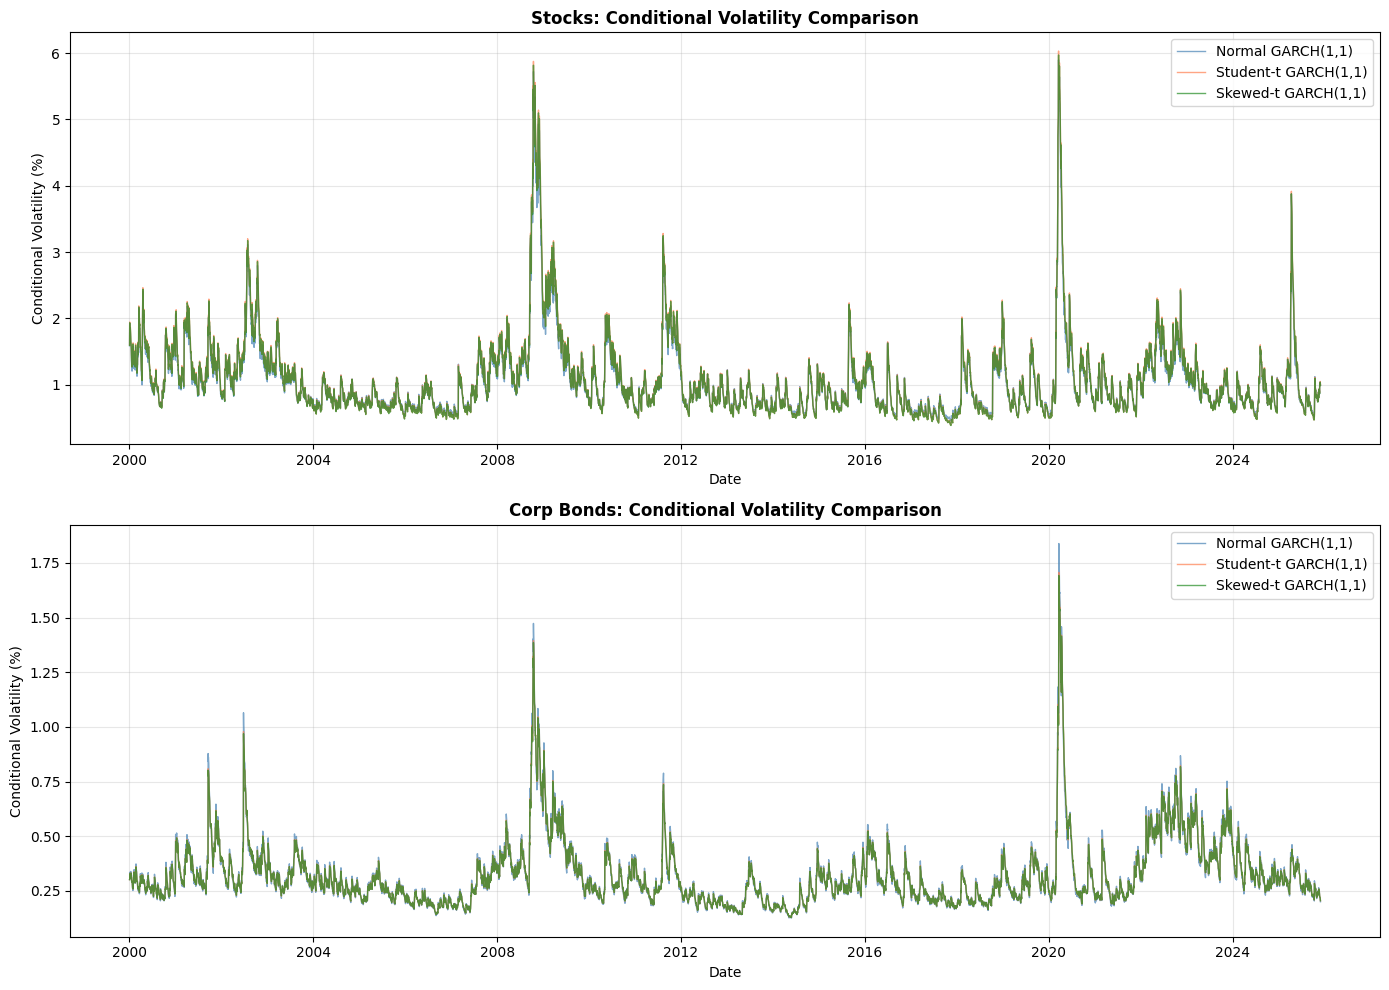

Volatility Comparison Summary Statistics

Stocks:
  Correlations:
    Normal vs Student-t:   0.999236
    Normal vs Skewed-t:    0.999087
    Student-t vs Skewed-t: 0.999974
  Mean Absolute Differences (%):
    Normal vs Student-t:   0.0341
    Normal vs Skewed-t:    0.0306
    Student-t vs Skewed-t: 0.0090

Corp Bonds:
  Correlations:
    Normal vs Student-t:   0.998085
    Normal vs Skewed-t:    0.997670
    Student-t vs Skewed-t: 0.999978
  Mean Absolute Differences (%):
    Normal vs Student-t:   0.0065
    Normal vs Skewed-t:    0.0071
    Student-t vs Skewed-t: 0.0007


In [80]:
# Extract conditional volatilities from all three GARCH specifications
volatility_data = {}

for asset_name in ['Stocks', 'Corp Bonds']:
    # Get dates from the index
    col = 'ar1_resid_lexreturn_stocks' if asset_name == 'Stocks' else 'ar1_resid_lexreturn_cbonds'
    dates = pdf_excess_returns[col].dropna().index
    
    # Extract volatilities (already in %)
    vol_normal = garch_results[asset_name]['model'].conditional_volatility
    vol_studentt = garch_t_results[asset_name]['model'].conditional_volatility
    vol_skewt = garch_skewt_results[asset_name]['model'].conditional_volatility
    
    volatility_data[asset_name] = {
        'dates': dates,
        'Normal': vol_normal,
        'Student-t': vol_studentt,
        'Skewed-t': vol_skewt
    }

# Create comparison plot
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

for idx, asset_name in enumerate(['Stocks', 'Corp Bonds']):
    ax = axes[idx]
    data = volatility_data[asset_name]
    
    # Plot all three volatility series
    ax.plot(data['dates'], data['Normal'], label='Normal GARCH(1,1)', 
            linewidth=1.0, alpha=0.7, color='steelblue')
    ax.plot(data['dates'], data['Student-t'], label='Student-t GARCH(1,1)', 
            linewidth=1.0, alpha=0.7, color='coral')
    ax.plot(data['dates'], data['Skewed-t'], label='Skewed-t GARCH(1,1)', 
            linewidth=1.0, alpha=0.7, color='forestgreen')
    
    ax.set_title(f'{asset_name}: Conditional Volatility Comparison', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Conditional Volatility (%)')
    ax.legend(loc='upper right')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Compute summary statistics for volatility differences
print("="*80)
print("Volatility Comparison Summary Statistics")
print("="*80)

for asset_name in ['Stocks', 'Corp Bonds']:
    data = volatility_data[asset_name]
    
    # Compute correlations
    corr_nt = np.corrcoef(data['Normal'], data['Student-t'])[0, 1]
    corr_ns = np.corrcoef(data['Normal'], data['Skewed-t'])[0, 1]
    corr_ts = np.corrcoef(data['Student-t'], data['Skewed-t'])[0, 1]
    
    # Compute mean absolute differences
    mad_nt = np.mean(np.abs(data['Normal'] - data['Student-t']))
    mad_ns = np.mean(np.abs(data['Normal'] - data['Skewed-t']))
    mad_ts = np.mean(np.abs(data['Student-t'] - data['Skewed-t']))
    
    print(f"\n{asset_name}:")
    print(f"  Correlations:")
    print(f"    Normal vs Student-t:   {corr_nt:.6f}")
    print(f"    Normal vs Skewed-t:    {corr_ns:.6f}")
    print(f"    Student-t vs Skewed-t: {corr_ts:.6f}")
    print(f"  Mean Absolute Differences (%):")
    print(f"    Normal vs Student-t:   {mad_nt:.4f}")
    print(f"    Normal vs Skewed-t:    {mad_ns:.4f}")
    print(f"    Student-t vs Skewed-t: {mad_ts:.4f}")

**Key Observations:**

1. **Visual Similarity**: The three volatility series (Normal, Student-t, Skewed-t) are nearly indistinguishable in the plots, tracking each other extremely closely over the entire sample period.

2. **Extremely High Correlations**: 
   - All pairwise correlations exceed 0.997
   - Student-t vs Skewed-t correlations are especially high (>0.9999)
   - This indicates that distributional assumptions have minimal impact on conditional variance estimates

3. **Negligible Absolute Differences**:
   - Mean absolute differences are all below 0.04% for stocks and 0.01% for corporate bonds
   - Student-t and Skewed-t produce nearly identical volatilities (MAD < 0.01%)
   - Normal GARCH differs slightly more but still within 0.03-0.04%

4. **Volatility Clustering Evidence**:
   - Clear spikes during crisis periods: 2001-2002 (dot-com crash), 2008-2009 (financial crisis), 2020 (COVID-19), and 2025
   - High persistence (α + β ≈ 0.99) means volatility shocks take a long time to dissipate
   - Both assets show similar patterns but stocks exhibit higher peak volatility

**Interpretation**:

The GARCH(1,1) conditional variance equation $\sigma_t^2 = \omega + \alpha\varepsilon_{t-1}^2 + \beta\sigma_{t-1}^2$ is **robust to distributional assumptions**. The parameter estimates (ω, α, β) are remarkably stable across Normal, Student-t, and Skewed-t specifications, leading to virtually identical volatility forecasts.

This robustness is precisely why **Quasi-Maximum Likelihood (QML)** estimation works: as long as the conditional variance equation is correctly specified, the choice of error distribution has minimal impact on volatility estimation. The distributional assumption matters primarily for:
- Standard error calculations (QML provides robust inference)
- Risk measures (VaR/ES quantiles depend critically on tail behavior)
- Likelihood-based model selection (AIC/BIC)

The high similarity between Student-t and Skewed-t volatilities suggests that **asymmetry (λ)** primarily affects the shape of the innovation distribution rather than the conditional variance dynamics. This validates the GARCH framework where asymmetry is modeled through the error distribution, not through the variance equation itself (unlike GJR-GARCH or EGARCH models that incorporate leverage effects directly).

---

## Section 3.4 Summary: Skewed Student-t GARCH(1,1)

This section extended the GARCH analysis to the Hansen (1994) skewed Student-t distribution, which nests both Normal (η→∞, λ=0) and Student-t (λ=0) as special cases.

**Key Findings:**

- **3.4a) Parameter Estimates**: η ≈ 6-8 (moderate tail thickness), λ ≈ -0.03 to -0.10 (negative skewness), confirming departures from normality and symmetry

- **3.4b) DGT Test Results**: Skewed-t provides better fit than Normal, but evidence of remaining misspecification suggests more complex dynamics may be present

- **3.4c) Moment Comparison**: Theoretical moments from Hansen distribution closely match sample moments of standardized innovations, validating the distributional choice

- **3.4d) Volatility Comparison**: Conditional volatilities are virtually identical across Normal, Student-t, and Skewed-t specifications (correlations > 0.997), confirming QML robustness

**Conclusion**: The skewed Student-t distribution successfully captures both fat tails and asymmetry in financial returns. However, the GARCH variance equation itself is remarkably robust to distributional assumptions, justifying QML estimation in practice.

In [83]:
def create_temporal_aggregation_table(freq_df, output_path):
    """
    Create LaTeX tabular for temporal aggregation analysis
    
    Args:
        freq_df: DataFrame with columns ['Frequency', 'N', 'Skewness', 'Kurtosis', 'JB-stat', 'JB p-value', 'LB Q-stat', 'LB p-value']
        output_path: Path to save LaTeX file
    """
    latex = []
    latex.append(r'\begin{tabular}{lrcccccc}')
    latex.append(r'\toprule')
    latex.append(r'Frequency & N & Skewness & Kurtosis & JB-stat & JB p-val & Q-stat & LB p-val \\')
    latex.append(r'\midrule')
    
    for _, row in freq_df.iterrows():
        # Format p-values
        if row['JB p-value'] < 0.00005:
            jb_pval = "0.0000"
        else:
            jb_pval = f"{row['JB p-value']:.4f}"
            
        if row['LB p-value'] < 0.00005:
            lb_pval = "0.0000"
        else:
            lb_pval = f"{row['LB p-value']:.4f}"
        
        latex.append(f"{row['Frequency']} & {row['N']} & {row['Skewness']:.3f} & {row['Kurtosis']:.3f} & {row['JB-stat']:.2f} & {jb_pval} & {row['LB Q-stat']:.2f} & {lb_pval} \\\\")
    
    latex.append(r'\bottomrule')
    latex.append(r'\end{tabular}')
    
    # Write to file
    latex_str = '\n'.join(latex)
    with open(output_path, 'w') as f:
        f.write(latex_str)
    
    return latex_str

# Generate the table
temporal_agg_file = os.path.join(TABLE_PATH, 'table_temporal_aggregation.tex')
temporal_agg_latex = create_temporal_aggregation_table(freq_df, temporal_agg_file)

print(f"Temporal aggregation table saved to: {temporal_agg_file}")
print("\nTemporal Aggregation Table Generated Successfully")

Temporal aggregation table saved to: c:\Users\palmunen\PR\git\financial_econometrics_I\tex_report\tables\table_temporal_aggregation.tex

Temporal Aggregation Table Generated Successfully
